# Testing notebook for nifty fit on atmosphere TODs directly (no image)

# Try to add a nifty model for sampling the input map

numpy version: 2.1.1


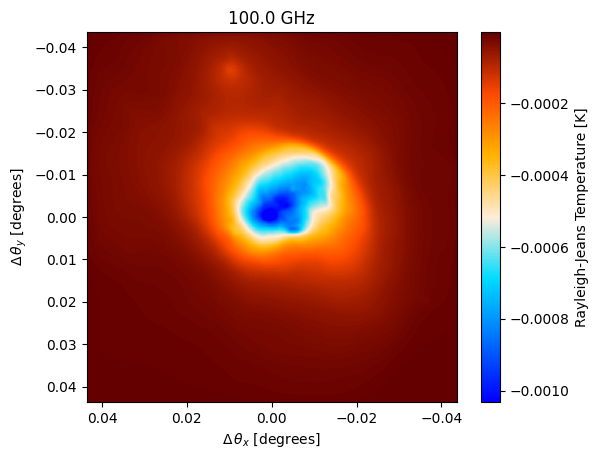

In [1]:
import numpy as np
print(f"numpy version: {np.__version__}")
import matplotlib.pyplot as plt
import maria
import sys
import os

# Relative import of sample_maps for now
sys.path.append(os.path.abspath('../python'))
import mapsampling_jax
from mapsampling_jax import sample_maps

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

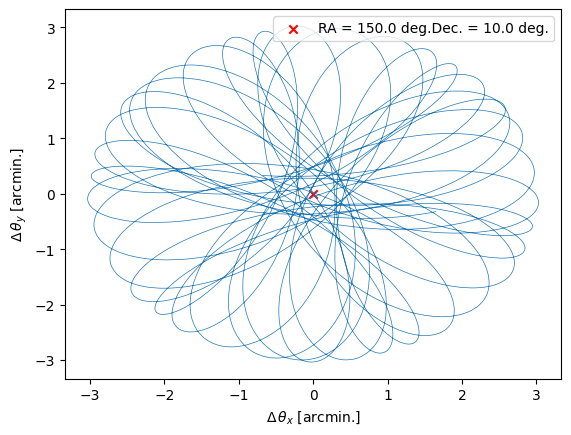

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                      # duration=300, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

2024-10-08 09:36:19.446 INFO: Constructed instrument.
2024-10-08 09:36:19.447 INFO: Constructed plan.
2024-10-08 09:36:19.447 INFO: Constructed site.
2024-10-08 09:36:20.073 INFO: Constructed boresight.
2024-10-08 09:36:20.619 INFO: Constructed offsets.


Initialized base in 1174 ms.


Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
Generating atmosphere: 4it [00:01,  3.86it/s]
Sampling map (m2/f093): 100%|██████████| 1/1 [00:05<00:00,  5.75s/it]


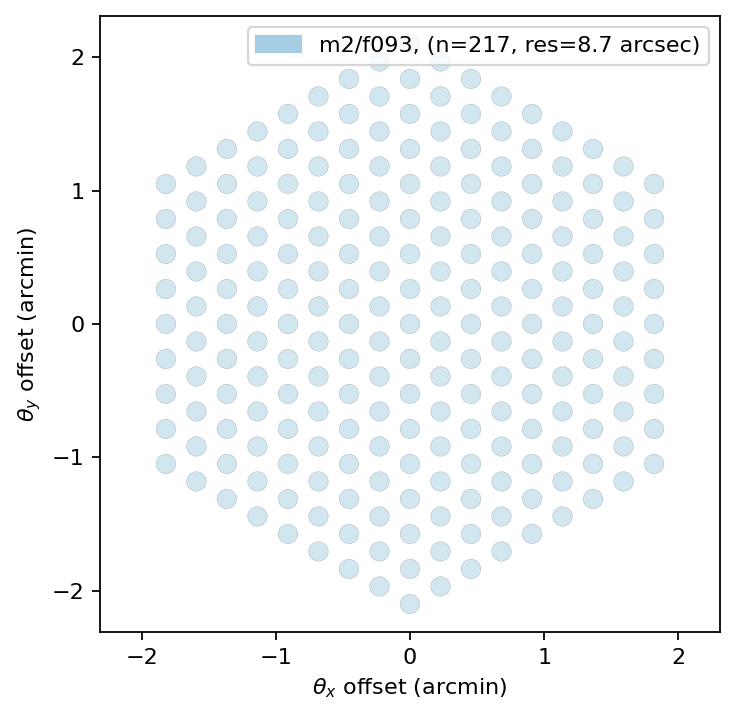

In [3]:
# instrument = maria.get_instrument('MUSTANG-2')
instrument = mapsampling_jax.instrument
instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

dx

array([[-1.96498059e-04, -1.93090613e-04, -1.90091664e-04, ...,
         4.73739401e-04,  4.76764109e-04,  4.80004742e-04],
       [-2.45625888e-04, -2.42218725e-04, -2.39220012e-04, ...,
         4.28384607e-04,  4.31409053e-04,  4.34649398e-04],
       [-1.21309209e-04, -1.17901819e-04, -1.14902918e-04, ...,
         5.49616894e-04,  5.52641566e-04,  5.55882161e-04],
       ...,
       [ 1.21335747e-04,  1.24745513e-04,  1.27746390e-04, ...,
         7.60700211e-04,  7.63727048e-04,  7.66970025e-04],
       [-4.04986207e-04, -4.01576046e-04, -3.98574837e-04, ...,
         2.29557762e-04,  2.32584850e-04,  2.35828089e-04],
       [-7.45886819e-04, -7.42479600e-04, -7.39480837e-04, ...,
        -7.22351429e-05, -6.92107429e-05, -6.59704615e-05]])

Running mapper (m2/f093): 100%|██████████| 1/1 [00:09<00:00,  9.69s/it]


mapdata_truth shape: (1, 1000, 1000)
mapdata_truth mean: -8.726028151723567e-05


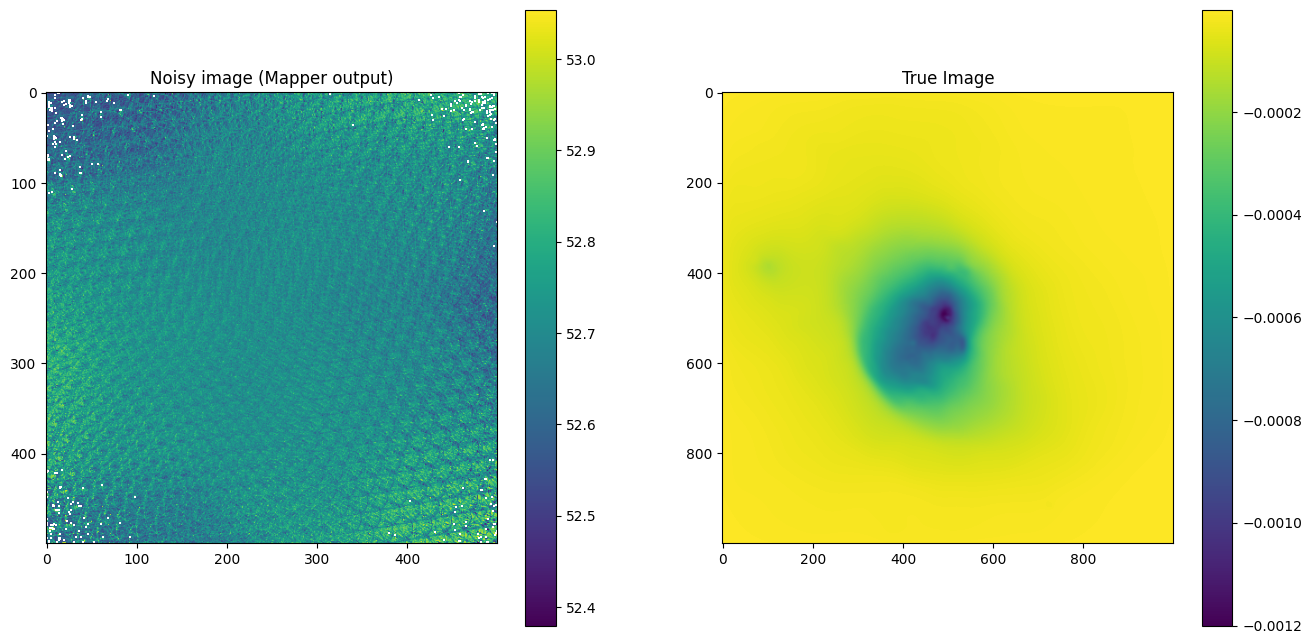

In [5]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0].T)
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
from jax import random
import jax.numpy as jnp

import nifty8.re as jft
import matplotlib.pyplot as plt

import numpy as np

from functools import reduce
from operator import or_

seed = 42
key = random.PRNGKey(seed)

2024-10-08 09:36:53.940 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-10-08 09:36:53.942 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Test TOD agreement:

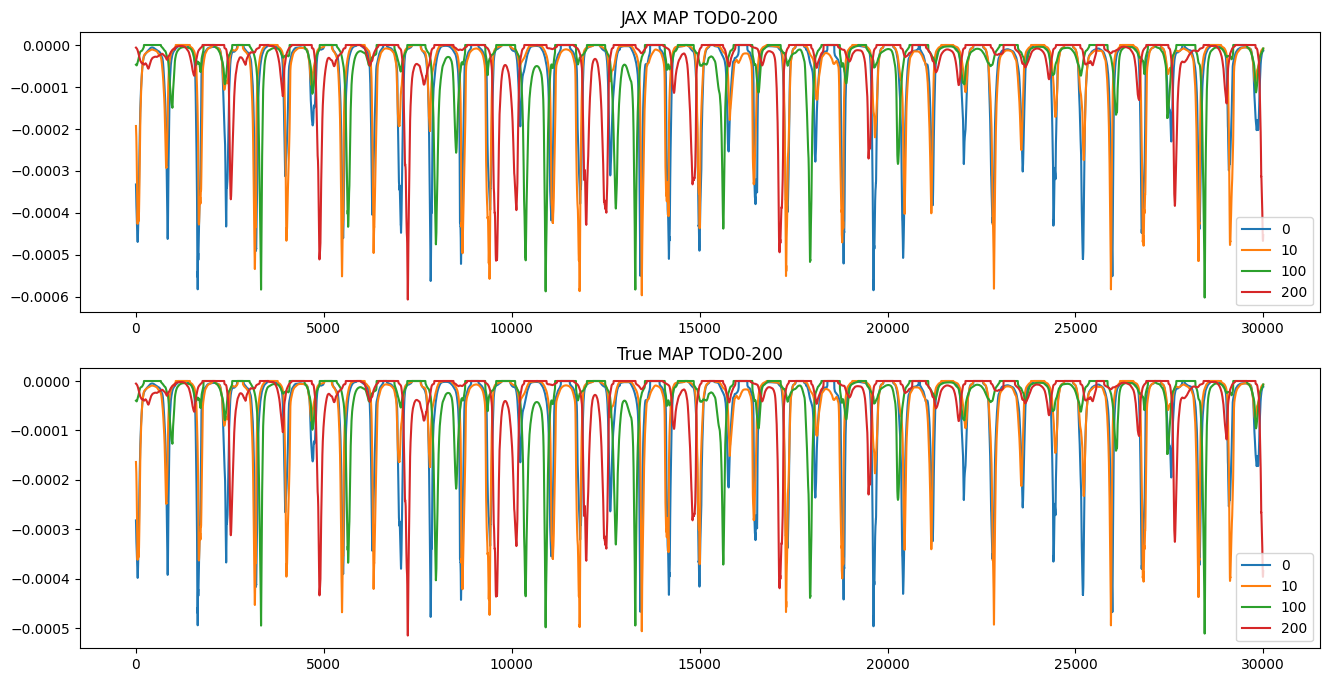

In [7]:
jax_tods_map = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods_map[i], label=i)

    tods_map = np.float64(tod_truthmap.components['map'].compute())
    im1 = axes[1].plot(tods_map[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True MAP TOD0-{i}')
axes[1].legend()

plt.show()

# Smooth atmosphere TODs:

In [8]:
import scipy as sp

jax_tods_atmos = tod_truthmap.components['atmosphere']
jax_tods_atmos_smooth = np.zeros(jax_tods_atmos.shape)

for i in range(jax_tods_atmos.shape[0]):
    jax_tods_atmos_smooth[i] = sp.ndimage.gaussian_filter1d(jax_tods_atmos[i], sigma=2e2)

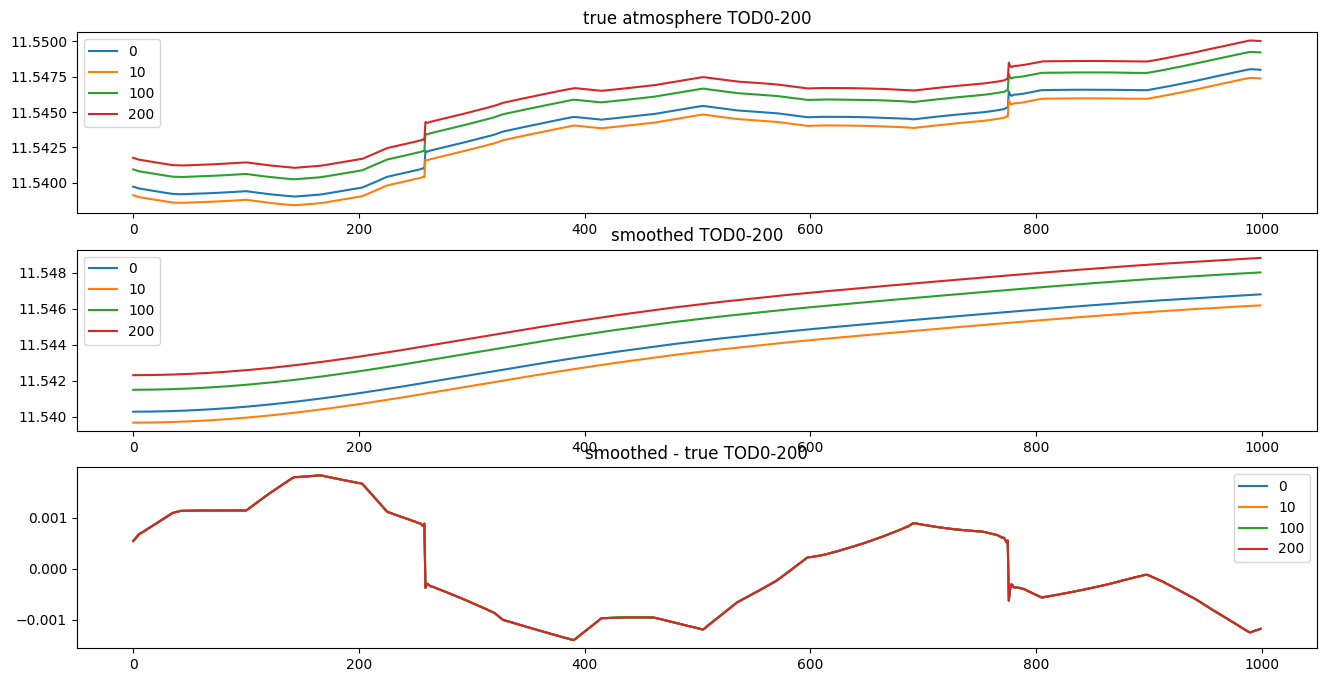

In [9]:
# plot smoothed atmos:

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods_atmos[i, 0:1000], label=i)
    im1 = axes[1].plot(jax_tods_atmos_smooth[i, 0:1000], label=i)
    im2 = axes[2].plot(jax_tods_atmos_smooth[i, 0:1000] - jax_tods_atmos[i, 0:1000], label=i)
    
axes[0].title.set_text(f'true atmosphere TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'smoothed TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'smoothed - true TOD0-{i}')
axes[2].legend()

plt.show()

# Prepare noised input TODs:

Noise stddev: 0.00025183574


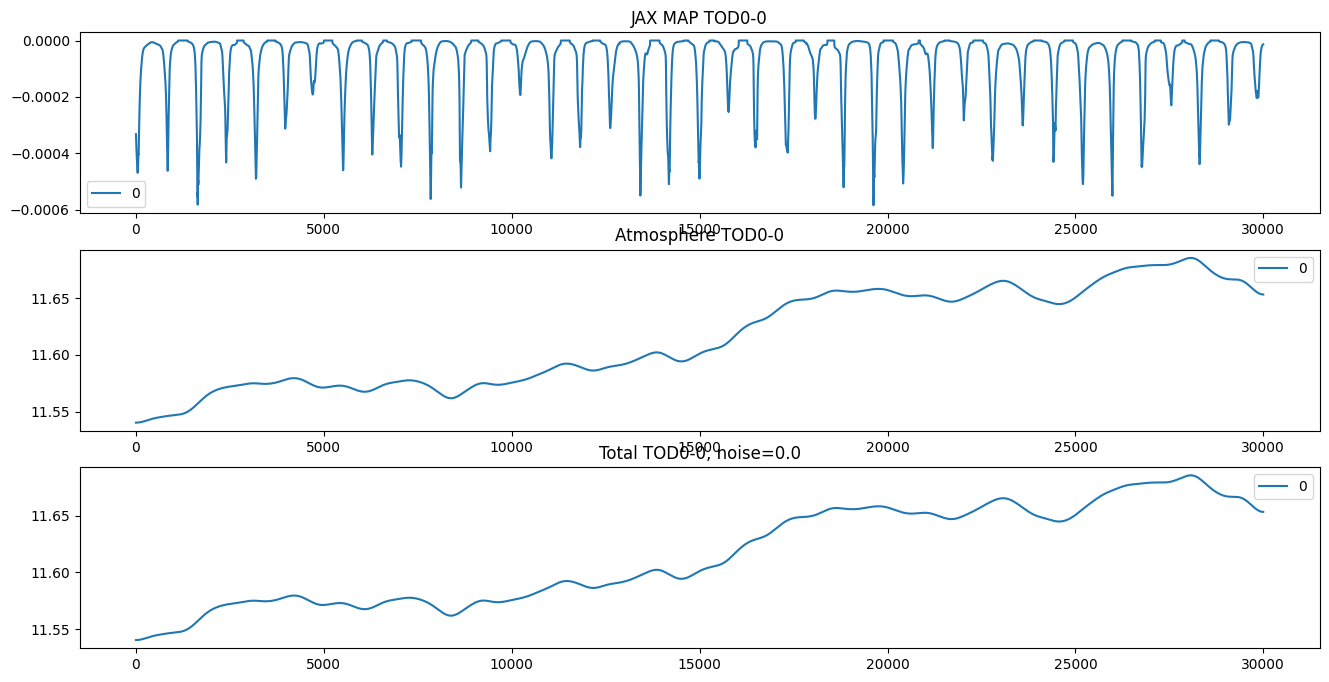

In [10]:
# Pick noise level for rest of run:
noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
# noiselevel = 1.0

# Add n TODs for atmos:
n = 1
# n = noised_jax_tod.shape[0]

jax_tods_atmos = tod_truthmap.components['atmosphere']
# noised_jax_tod = np.float64(jax_tods_map) + np.float64(jax_tods_atmos) + np.float64(tod_truthmap.components['noise']*noiselevel)

noised_jax_tod = np.float64(jax_tods_map) + np.float64(tod_truthmap.components['noise']*noiselevel)
# noised_jax_tod[:n] += np.float64(jax_tods_atmos[:n]) 
noised_jax_tod[:n] = np.float64(jax_tods_atmos_smooth[:n])

print("Noise stddev:", np.std(tod_truthmap.components['noise'].compute()))

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

# for i in [0, 10, 100, 200]:
for i in [0]:
    im0 = axes[0].plot(jax_tods_map[i], label=i)
    # im1 = axes[1].plot(jax_tods_atmos[i], label=i)
    im1 = axes[1].plot(jax_tods_atmos_smooth[i], label=i)
    im2 = axes[2].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'Atmosphere TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'Total TOD0-{i}, noise={noiselevel}')
axes[2].legend()

plt.show()

# Next, initialise nifty prior model

Start with the atmosphere TOD model:

In [11]:
dims_atmos = (jax_tods_atmos.shape[1] + 2000,)
padding_atmos = dims_atmos[0] - jax_tods_atmos.shape[1]

# correlated field zero mode GP offset and stddev
# cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.001, 0.1))
cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.0005, 0.001))

# correlated field fluctuations (mostly don't need tuning)
# fluctuations: y-offset in power spectrum in fourier space (zero mode)
# loglogavgslope: power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
# flexibility=(1.5e0, 5e-1), # deviation from simple power-law
# asperity=(5e-1, 5e-2), # small scale features in power-law
cf_fl_tod = dict(
    fluctuations=(0.005, 0.005), 
    loglogavgslope=(-3, 0.5), 
    flexibility=None,
    asperity=None,
)

# put together in correlated field model
cfm_tod = jft.CorrelatedFieldMaker("")
cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
cfm_tod.add_fluctuations(
    dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
)
# gp_tod = cfm_tod.finalize()

## Add one Correlated field per TOD with shared flucts and zero-mean

In [12]:
# init params for each TOD:

gps_tods = []
for i in range(n):
    cfmi = jft.CorrelatedFieldMaker(f'tod{i} ')
    # cfmi.set_amplitude_total_offset(**cf_zm_tod)
    cfmi._azm = cfm_tod._azm
    cfmi._offset_mean = cfm_tod._offset_mean
    cfmi._parameter_tree['zeromode'] = jft.ShapeWithDtype(())

    cfmi._fluctuations.append(cfm_tod._fluctuations[0])
    cfmi._target_grids.append(cfm_tod._target_grids[0])
    cfmi._parameter_tree.update(cfm_tod._fluctuations[0].domain)
    gps_tods.append(cfmi.finalize())

## Now for the map model:

In [13]:
dims_map = (1000, 1000)

# Map model

# correlated field zero mode GP offset and stddev
cf_zm_map = dict(offset_mean=-8.7e-5, offset_std=(5e-6, 5e-6))
# correlated field fluctuations (mostly don't need tuning)
cf_fl_map = dict(
    fluctuations=(1e-3, 1e-4), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    loglogavgslope=(-3e0, 5e-1), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    flexibility=None,
    asperity=None,
    # flexibility=(1.5e0, 5e-1), # deviation from simple power-law
    # asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm_map = jft.CorrelatedFieldMaker("cfmap")
cfm_map.set_amplitude_total_offset(**cf_zm_map)
cfm_map.add_fluctuations(
    dims_map, distances=1.0 / dims_map[0], **cf_fl_map, prefix="ax1", non_parametric_kind="power"
)
gp_map = cfm_map.finalize()

In [14]:
# only tod:
class Signal_TOD(jft.Model):
    def __init__(self, gps_tods):
        # self.gp_tod = gp_tod
        # super().__init__(init=self.gp_tod.init, domain=jft.Vector(gp_tod.domain))
        self.gps_tods = gps_tods
        self.tgt = (len(gps_tods), gps_tods[0].target.size)
        # self.gp_map = gp_map
        # super().__init__(init=reduce(or_, [gp.init for gp in gps_tods] + [gp_map.init]), domain=reduce(or_, [gp.domain for gp in gps_tods] + [gp_map.domain]))
        super().__init__(init=reduce(or_, [gp.init for gp in gps_tods]), domain=reduce(or_, [gp.domain for gp in gps_tods]))
    
    def __call__(self, x):
        res_tods = jnp.zeros(self.tgt)
        for i, gp in enumerate(self.gps_tods):
            res_tods = res_tods.at[i].set(gp(x))
        
        return res_tods[:, padding_atmos//2:-padding_atmos//2]

        # res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

        # # Only add first n atmosphere tods, otherwise use map
        # modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])

        # return modified_res_map

signal_response_tod = Signal_TOD(gps_tods)

In [15]:
# Define simple signal model with added map sampling
# class Signal_TOD(jft.Model):
#     def __init__(self, gps_tods, gp_map):
#         # self.gp_tod = gp_tod
#         # super().__init__(init=self.gp_tod.init, domain=jft.Vector(gp_tod.domain))
#         self.gps_tods = gps_tods
#         self.tgt = (len(gps_tods), gps_tods[0].target.size)
#         self.gp_map = gp_map
#         super().__init__(init=reduce(or_, [gp.init for gp in gps_tods] + [gp_map.init]), domain=reduce(or_, [gp.domain for gp in gps_tods] + [gp_map.domain]))
    
#     def __call__(self, x):
#         res_tods = jnp.zeros(self.tgt)
#         for i, gp in enumerate(self.gps_tods):
#             res_tods = res_tods.at[i].set(gp(x))
        
#         res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

#         # Only add first n atmosphere tods, otherwise use map
#         modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])

#         return modified_res_map
#         # return res_tods[:, padding_atmos//2:-padding_atmos//2] + res_map
#         # return res_tods[:, padding_atmos//2:-padding_atmos//2] + res_map[:n]

# signal_response_tod = Signal_TOD(gps_tods, gp_map)

# map only:
# class Signal_TOD(jft.Model):
#     def __init__(self, gp_map):
#         # self.gp_tod = gp_tod
#         # super().__init__(init=self.gp_tod.init, domain=jft.Vector(gp_tod.domain))
#         # self.gps_tods = gps_tods
#         # self.tgt = (len(gps_tods), gps_tods[0].target.size)
#         self.gp_map = gp_map
#         # super().__init__(init=reduce(or_, [gp.init for gp in gps_tods] + [gp_map.init]), domain=reduce(or_, [gp.domain for gp in gps_tods] + [gp_map.domain]))
#         super().__init__(init=gp_map.init, domain=gp_map.domain)
    
#     def __call__(self, x):
#         # res_tods = jnp.zeros(self.tgt)
#         # for i, gp in enumerate(self.gps_tods):
#         #     res_tods = res_tods.at[i].set(gp(x))
        
#         res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
#         return res_map

#         # Only add first n atmosphere tods, otherwise use map
#         # modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])

#         # return modified_res_map
#         # return res_tods[:, padding_atmos//2:-padding_atmos//2] + res_map
#         # return res_tods[:, padding_atmos//2:-padding_atmos//2] + res_map[:n]
  
# signal_response_tod = Signal_TOD(gp_map)

# Define noise covariance
# if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x

# Combine in likelihood - only fit 0th TOD for now!
truth = noised_jax_tod[:n]
# truth = noised_jax_tod
lh_tod = jft.Gaussian( truth, noise_cov_inv_tod).amend(signal_response_tod)

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

# lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


In [16]:
signal_response_tod

Signal_TOD(
	<bound method Signal_TOD.__call__>,
	domain={'tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'tod0 xi': ShapeWithDtype(shape=(32000,), dtype=<class 'jax.numpy.float64'>),
	 'zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'tod fluctuations': functools.partial(<function random_like at 0x7fc6901d1620>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'tod loglogavgslope': functools.partial(<function random_like at 0x7fc6901d1620>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'tod0 xi': functools.partial(<function random_like at 0x7fc6901d1620>, primals=ShapeWithDtype(shape=(32000,), dtype=<class 'jax.numpy.float64'>)),
		 'zeromode': functools.partial(<function random_like at 0x7fc6901d1620>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>))

# Draw Prior sample

(1, 30000)


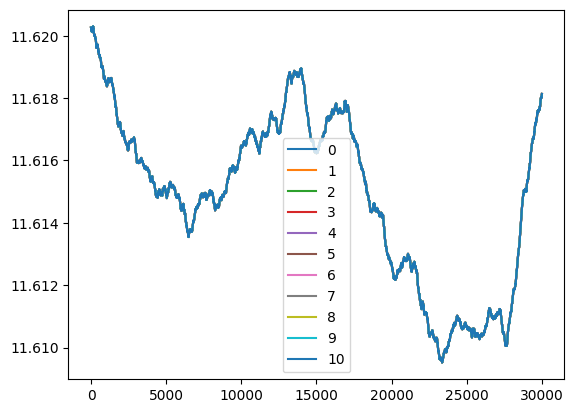

In [17]:
key, sub = jax.random.split(key)
xi = jft.random_like(sub, signal_response_tod.domain)
res = signal_response_tod(xi)
print(res.shape)

# for i in range(res.shape[0]):
for i in range(11):
    plt.plot(np.arange(0, res.shape[1]), res[i], label=i)
plt.legend()
plt.show()

# MAP fit

In [18]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:1.0 ↺:False #∇²:06 |↘|:6.756898e+01 ➽:3.200300e+00
M: Iteration 1 ⛰:+9.141438e+16 Δ⛰:7.923175e+16
M: →:0.5 ↺:False #∇²:12 |↘|:5.096523e+01 ➽:3.200300e+00
M: Iteration 2 ⛰:+1.319571e+16 Δ⛰:7.821867e+16
M: →:1.0 ↺:False #∇²:18 |↘|:2.505461e+01 ➽:3.200300e+00
M: Iteration 3 ⛰:+1.444877e+15 Δ⛰:1.175083e+16
M: →:1.0 ↺:False #∇²:24 |↘|:2.830969e+01 ➽:3.200300e+00
M: Iteration 4 ⛰:+7.829025e+14 Δ⛰:6.619745e+14
M: →:1.0 ↺:False #∇²:30 |↘|:1.360985e+01 ➽:3.200300e+00
M: Iteration 5 ⛰:+5.409595e+14 Δ⛰:2.419429e+14
M: →:1.0 ↺:False #∇²:38 |↘|:3.527363e+01 ➽:3.200300e+00
M: Iteration 6 ⛰:+2.929229e+14 Δ⛰:2.480366e+14
M: →:1.0 ↺:False #∇²:44 |↘|:6.486834e+00 ➽:3.200300e+00
M: Iteration 7 ⛰:+2.130259e+14 Δ⛰:7.989699e+13
M: →:1.0 ↺:False #∇²:52 |↘|:2.530364e+01 ➽:3.200300e+00
M: Iteration 8 ⛰:+1.465153e+14 Δ⛰:6.651066e+13
M: →:1.0 ↺:False #∇²:58 |↘|:3.545642e+00 ➽:3.200300e+00
M: Iteration 9 ⛰:+1.128343e+14 Δ⛰:3.368093e+13
M: →:1.0 ↺:False #∇²:66 |↘|:2.573012e+01 ➽:3.2

In [19]:
samples.pos

Vector(
	{'tod fluctuations': Array(0.93791586, dtype=float64),
	 'tod loglogavgslope': Array(1.37633887, dtype=float64),
	 'tod0 xi': Array([-2.51647033,  5.73665091,  1.84409799, ..., -8.01214225,
	       -3.72335054, -5.89755139], dtype=float64),
	 'zeromode': Array(0.54520238, dtype=float64)}
)

In [20]:
def printfitresults():
    print("Fit Results (res, init, std)")

    print("\nTODs:")
    print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")
    print(f"\tzeromode std (Normal): {jft.NormalPrior(*cf_zm_tod['offset_std'])(samples.pos['zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")

    # print("map:")
    # print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_map['fluctuations'])(samples.pos['cfmapax1fluctuations'])}, {cf_fl_map['fluctuations'][0]}, {cf_fl_map['fluctuations'][1]}")
    # print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_map['loglogavgslope'])(samples.pos['cfmapax1loglogavgslope'])}, {cf_fl_map['loglogavgslope'][0]}, {cf_fl_map['loglogavgslope'][1]}")
    # print(f"\tzeromode std: {jft.NormalPrior(*cf_zm_map['offset_std'])(samples.pos['zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")
    
    # for i in range(n):
    #     test = samples.pos[f"tod{i} zeromode"]
    #     print(f"tod{i} zeromode: {jft.LogNormalPrior(cf_zm_tod['offset_mean'], cf_zm_tod['offset_std'][0])(test)}, {cf_zm_tod['offset_mean']}, {cf_zm_tod['offset_std'][0]}")
    
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.007719352583878207, 0.005, 0.005
	loglogvarslope: -2.311830565068504, -3, 0.5
	zeromode std (LogNormal): 0.00044655056286710653, 0.0005, 0.001
	zeromode std (Normal): 0.0010452023771292788, 0.0005, 0.001


(1, 30000)


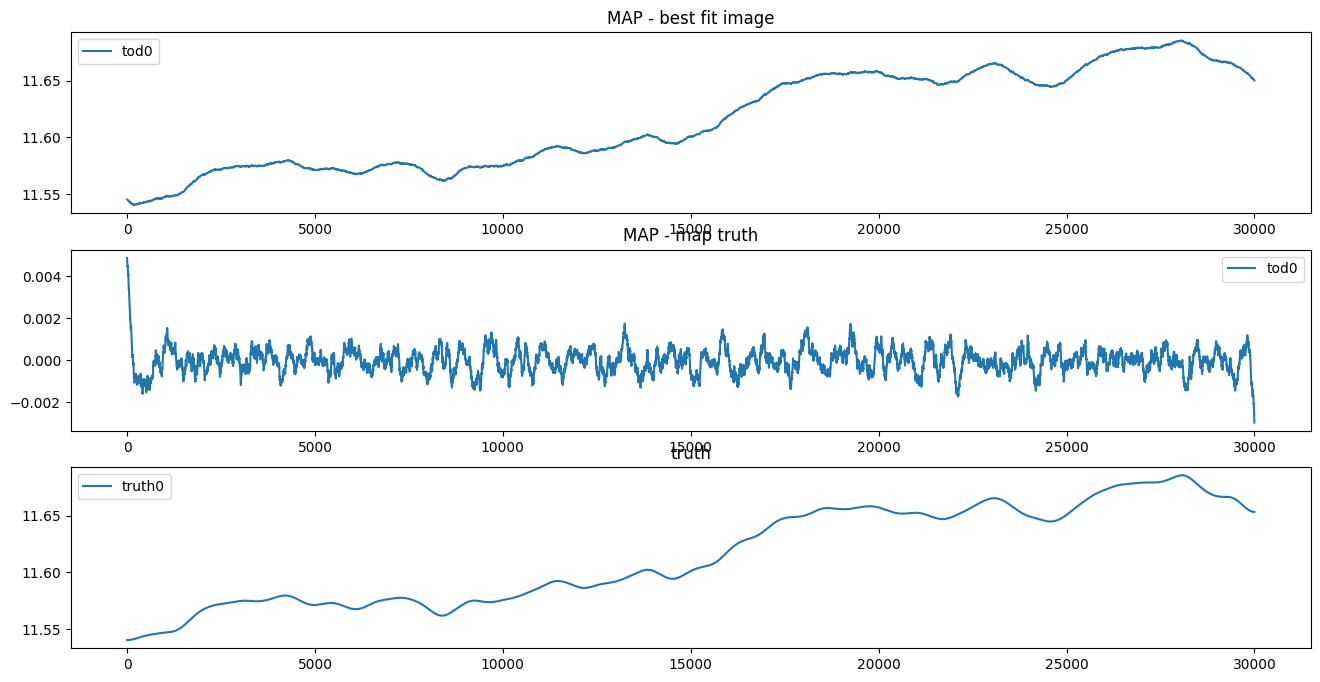

In [21]:
res = signal_response_tod(samples.pos)
print(res.shape)

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

# for i in range(0, res.shape[0], res.shape[0]//10):
for i in range(1):
    im0 = axes[0].plot(np.arange(0, res.shape[1]), res[i], label=f"tod{i}")
    im1 = axes[1].plot(np.arange(0, res.shape[1]), res[i] - truth[i], label=f"tod{i}")
    im2 = axes[2].plot(truth[i], label=f"truth{i}")

axes[0].title.set_text('MAP - best fit image')
axes[0].legend()
axes[1].title.set_text('MAP - map truth')
axes[1].legend()
axes[2].title.set_text('truth')
axes[2].legend()

plt.show()

In [22]:
# # plot maximum of posterior (mode)
# # sig_map = signal_response(samples.pos) # gives time-series
# sig_map = gp_map(samples.pos) # when splitting up in different field models

# fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# im0 = axes[0].imshow(sig_map)
# axes[0].title.set_text('MAP - best fit image')
# fig.colorbar(im0)

# im1 = axes[1].imshow( sig_map - mapdata_truth[0] )
# axes[1].title.set_text('MAP - map truth')
# # im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# # axes[1].title.set_text('diff prediction - map truth')
# fig.colorbar(im1)

# plt.show()

In [23]:
# assert False

## Full nifty fit:

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+5.7737e+14 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+1.7534e+14 Δ⛰:4.0203e+14 ➽:3.2003e-08
SL: Iteration 2 ⛰:+4.3361e+13 Δ⛰:1.3198e+14 ➽:3.2003e-08
SL: Iteration 3 ⛰:+2.6131e+13 Δ⛰:1.7230e+13 ➽:3.2003e-08
SL: Iteration 4 ⛰:+1.9484e+13 Δ⛰:6.6466e+12 ➽:3.2003e-08
SL: Iteration 5 ⛰:+8.8333e+12 Δ⛰:1.0651e+13 ➽:3.2003e-08
SL: Iteration 6 ⛰:+5.5753e+12 Δ⛰:3.2581e+12 ➽:3.2003e-08
SL: Iteration 7 ⛰:+3.2820e+12 Δ⛰:2.2933e+12 ➽:3.2003e-08
SL: Iteration 8 ⛰:+1.9893e+12 Δ⛰:1.2926e+12 ➽:3.2003e-08
SL: Iteration 9 ⛰:+1.2506e+12 Δ⛰:7.3873e+11 ➽:3.2003e-08
SL: Iteration 10 ⛰:+9.1823e+11 Δ⛰:3.3237e+11 ➽:3.2003e-08
SL: Iteration 11 ⛰:+7.8183e+11 Δ⛰:1.3640e+11 ➽:3.2003e-08
SL: Iteration 12 ⛰:+6.8832e+11 Δ⛰:9.3509e+10 ➽:3.2003e-08
SL: Iteration 13 ⛰:+5.4974e+11 Δ⛰:1.3858e+11 ➽:3.2003e-08
SL: Iteration 14 ⛰:+5.4884e+11 Δ⛰:9.0678e+08 ➽:3.2003e-08
SL: Iteration 15 ⛰:+3.7591e+11 Δ⛰:1.7293e+11 ➽:3.2003e-08
SL: Iteration 16 ⛰:+3.0579e+11 Δ⛰:7.0118e+10 ➽:3.2003e-08
SL: 

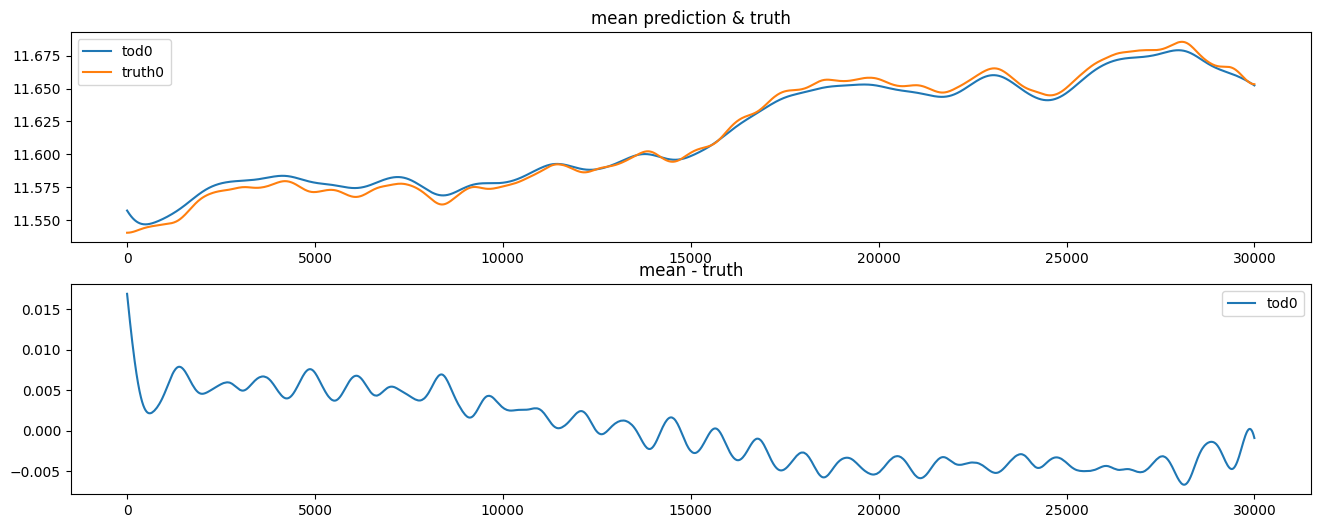

OPTIMIZE_KL: Starting 0002
SL: Iteration 0 ⛰:+2.0788e+17 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+4.0873e+16 Δ⛰:1.6701e+17 ➽:3.2003e-08
SL: Iteration 2 ⛰:+6.5497e+15 Δ⛰:3.4323e+16 ➽:3.2003e-08
SL: Iteration 3 ⛰:+2.1866e+15 Δ⛰:4.3631e+15 ➽:3.2003e-08
SL: Iteration 4 ⛰:+1.3409e+14 Δ⛰:2.0525e+15 ➽:3.2003e-08
SL: Iteration 5 ⛰:+9.0336e+13 Δ⛰:4.3751e+13 ➽:3.2003e-08
SL: Iteration 6 ⛰:+2.9097e+13 Δ⛰:6.1239e+13 ➽:3.2003e-08
SL: Iteration 7 ⛰:+2.5929e+13 Δ⛰:3.1681e+12 ➽:3.2003e-08
SL: Iteration 8 ⛰:+2.5921e+13 Δ⛰:8.1362e+09 ➽:3.2003e-08
SL: Iteration 9 ⛰:+1.9431e+13 Δ⛰:6.4898e+12 ➽:3.2003e-08
SL: Iteration 10 ⛰:+1.9042e+13 Δ⛰:3.8857e+11 ➽:3.2003e-08
SL: Iteration 11 ⛰:+1.1168e+13 Δ⛰:7.8737e+12 ➽:3.2003e-08
SL: Iteration 12 ⛰:+8.8428e+12 Δ⛰:2.3257e+12 ➽:3.2003e-08
SL: Iteration 13 ⛰:+8.4361e+12 Δ⛰:4.0672e+11 ➽:3.2003e-08
SL: Iteration 14 ⛰:+5.3663e+12 Δ⛰:3.0698e+12 ➽:3.2003e-08
SL: Iteration 15 ⛰:+5.3620e+12 Δ⛰:4.2185e+09 ➽:3.2003e-08
SL: Iteration 16 ⛰:+3.7419e+12 Δ⛰:1.6202e+12 ➽:3.2003e-08
SL: 

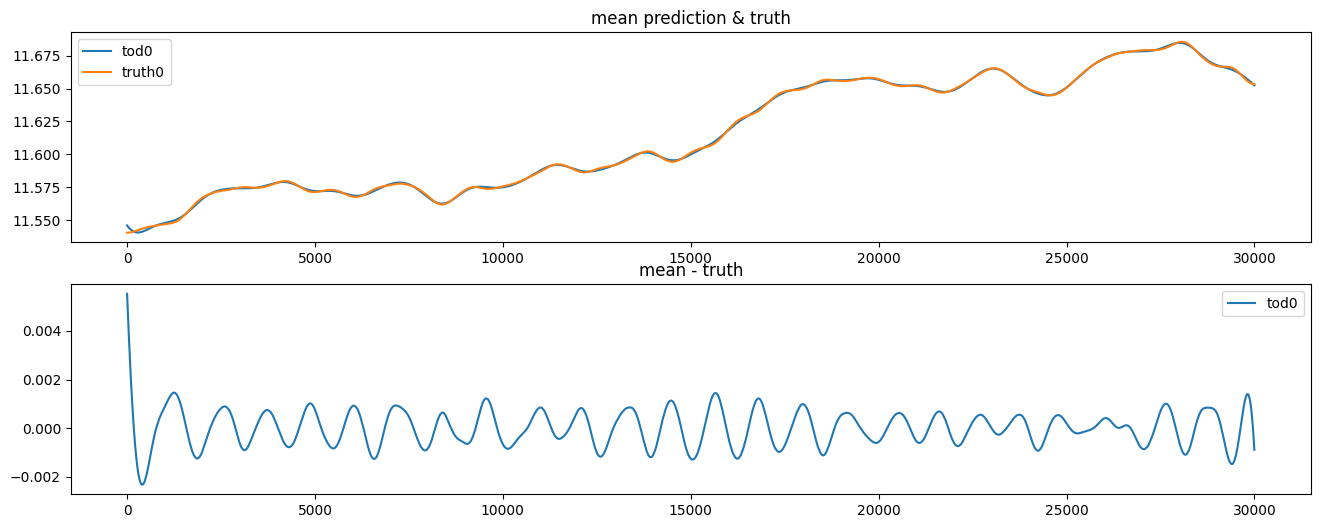

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:+5.5633e+17 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+9.2932e+15 Δ⛰:5.4704e+17 ➽:3.2003e-08
SL: Iteration 2 ⛰:+3.0640e+15 Δ⛰:6.2292e+15 ➽:3.2003e-08
SL: Iteration 3 ⛰:+8.7523e+14 Δ⛰:2.1888e+15 ➽:3.2003e-08
SL: Iteration 4 ⛰:+2.4810e+14 Δ⛰:6.2713e+14 ➽:3.2003e-08
SL: Iteration 5 ⛰:+1.1508e+14 Δ⛰:1.3302e+14 ➽:3.2003e-08
SL: Iteration 6 ⛰:+9.3332e+13 Δ⛰:2.1743e+13 ➽:3.2003e-08
SL: Iteration 7 ⛰:+3.7434e+13 Δ⛰:5.5898e+13 ➽:3.2003e-08
SL: Iteration 8 ⛰:+3.7353e+13 Δ⛰:8.1558e+10 ➽:3.2003e-08
SL: Iteration 9 ⛰:+2.7476e+13 Δ⛰:9.8768e+12 ➽:3.2003e-08
SL: Iteration 10 ⛰:+1.3653e+13 Δ⛰:1.3823e+13 ➽:3.2003e-08
SL: Iteration 11 ⛰:+1.3594e+13 Δ⛰:5.9589e+10 ➽:3.2003e-08
SL: Iteration 12 ⛰:+1.0553e+13 Δ⛰:3.0401e+12 ➽:3.2003e-08
SL: Iteration 13 ⛰:+1.0475e+13 Δ⛰:7.8396e+10 ➽:3.2003e-08
SL: Iteration 14 ⛰:+8.3445e+12 Δ⛰:2.1305e+12 ➽:3.2003e-08
SL: Iteration 15 ⛰:+6.4424e+12 Δ⛰:1.9021e+12 ➽:3.2003e-08
SL: Iteration 16 ⛰:+4.0389e+12 Δ⛰:2.4035e+12 ➽:3.2003e-08
SL: 

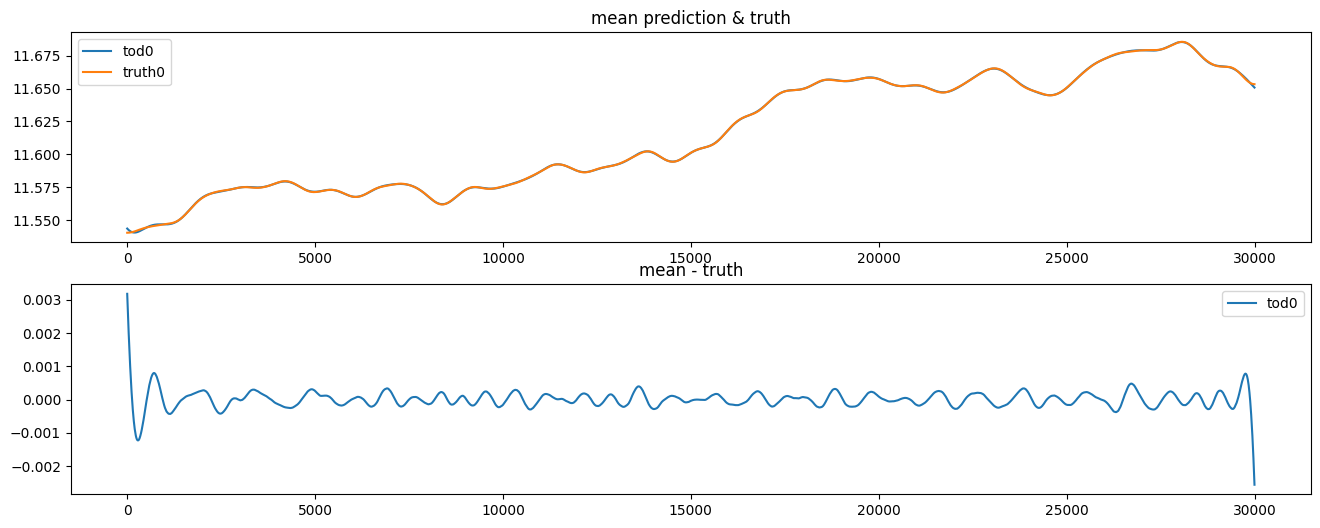

OPTIMIZE_KL: Starting 0004
SL: Iteration 0 ⛰:+3.5399e+17 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+4.2823e+16 Δ⛰:3.1117e+17 ➽:3.2003e-08
SL: Iteration 2 ⛰:+2.1148e+15 Δ⛰:4.0708e+16 ➽:3.2003e-08
SL: Iteration 3 ⛰:+1.2445e+15 Δ⛰:8.7026e+14 ➽:3.2003e-08
SL: Iteration 4 ⛰:+8.5051e+14 Δ⛰:3.9403e+14 ➽:3.2003e-08
SL: Iteration 5 ⛰:+1.9133e+14 Δ⛰:6.5918e+14 ➽:3.2003e-08
SL: Iteration 6 ⛰:+1.6685e+14 Δ⛰:2.4475e+13 ➽:3.2003e-08
SL: Iteration 7 ⛰:+7.9733e+13 Δ⛰:8.7119e+13 ➽:3.2003e-08
SL: Iteration 8 ⛰:+7.9685e+13 Δ⛰:4.8428e+10 ➽:3.2003e-08
SL: Iteration 9 ⛰:+6.7158e+13 Δ⛰:1.2527e+13 ➽:3.2003e-08
SL: Iteration 10 ⛰:+2.6154e+13 Δ⛰:4.1004e+13 ➽:3.2003e-08
SL: Iteration 11 ⛰:+2.6055e+13 Δ⛰:9.8996e+10 ➽:3.2003e-08
SL: Iteration 12 ⛰:+1.8669e+13 Δ⛰:7.3858e+12 ➽:3.2003e-08
SL: Iteration 13 ⛰:+1.5869e+13 Δ⛰:2.8001e+12 ➽:3.2003e-08
SL: Iteration 14 ⛰:+1.5855e+13 Δ⛰:1.3479e+10 ➽:3.2003e-08
SL: Iteration 15 ⛰:+1.5852e+13 Δ⛰:3.3338e+09 ➽:3.2003e-08
SL: Iteration 16 ⛰:+1.4647e+13 Δ⛰:1.2052e+12 ➽:3.2003e-08
SL: 

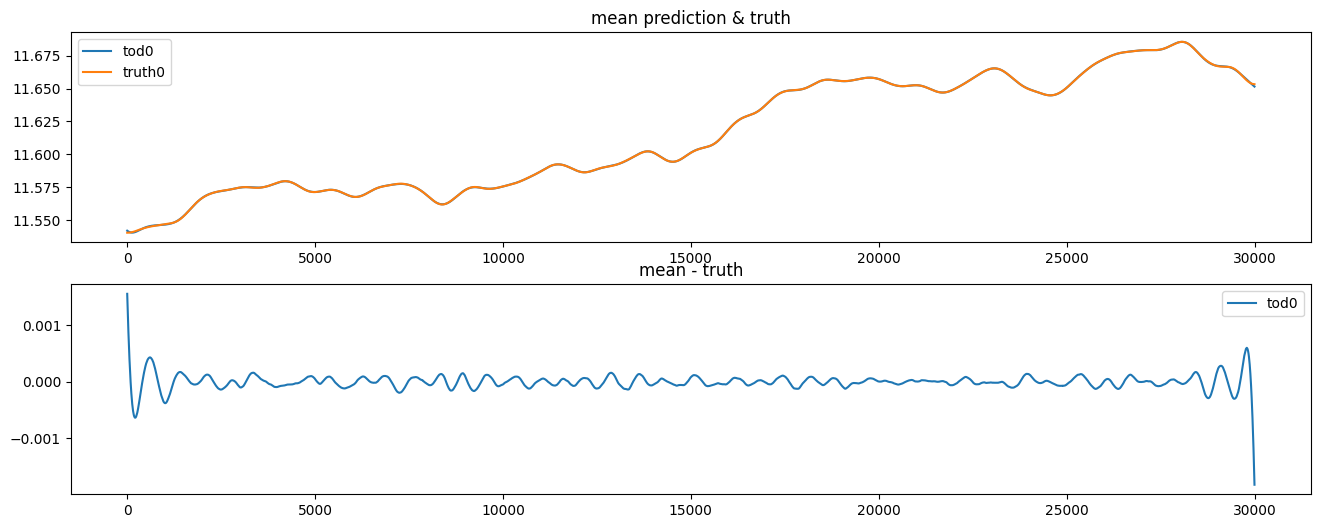

OPTIMIZE_KL: Starting 0005
SL: Iteration 0 ⛰:+2.3883e+17 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+3.2438e+16 Δ⛰:2.0639e+17 ➽:3.2003e-08
SL: Iteration 2 ⛰:+1.1949e+16 Δ⛰:2.0488e+16 ➽:3.2003e-08
SL: Iteration 3 ⛰:+2.4024e+15 Δ⛰:9.5469e+15 ➽:3.2003e-08
SL: Iteration 4 ⛰:+2.2894e+14 Δ⛰:2.1734e+15 ➽:3.2003e-08
SL: Iteration 5 ⛰:+1.4174e+14 Δ⛰:8.7200e+13 ➽:3.2003e-08
SL: Iteration 6 ⛰:+1.3265e+14 Δ⛰:9.0963e+12 ➽:3.2003e-08
SL: Iteration 7 ⛰:+9.4168e+13 Δ⛰:3.8480e+13 ➽:3.2003e-08
SL: Iteration 8 ⛰:+9.4097e+13 Δ⛰:7.0449e+10 ➽:3.2003e-08
SL: Iteration 9 ⛰:+5.8919e+13 Δ⛰:3.5179e+13 ➽:3.2003e-08
SL: Iteration 10 ⛰:+2.8641e+13 Δ⛰:3.0278e+13 ➽:3.2003e-08
SL: Iteration 11 ⛰:+2.8586e+13 Δ⛰:5.4300e+10 ➽:3.2003e-08
SL: Iteration 12 ⛰:+2.1072e+13 Δ⛰:7.5148e+12 ➽:3.2003e-08
SL: Iteration 13 ⛰:+1.8175e+13 Δ⛰:2.8968e+12 ➽:3.2003e-08
SL: Iteration 14 ⛰:+1.6663e+13 Δ⛰:1.5116e+12 ➽:3.2003e-08
SL: Iteration 15 ⛰:+1.6659e+13 Δ⛰:4.0232e+09 ➽:3.2003e-08
SL: Iteration 16 ⛰:+1.4883e+13 Δ⛰:1.7765e+12 ➽:3.2003e-08
SL: 

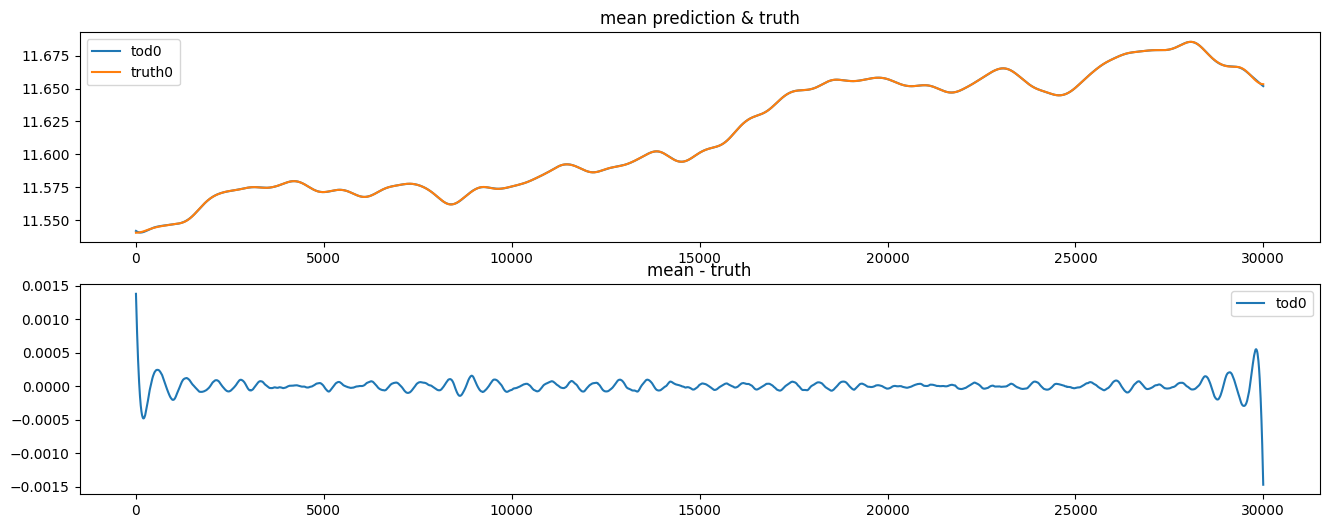

OPTIMIZE_KL: Starting 0006
SL: Iteration 0 ⛰:+2.0084e+17 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+5.4885e+15 Δ⛰:1.9535e+17 ➽:3.2003e-08
SL: Iteration 2 ⛰:+3.4534e+15 Δ⛰:2.0351e+15 ➽:3.2003e-08
SL: Iteration 3 ⛰:+1.9301e+15 Δ⛰:1.5232e+15 ➽:3.2003e-08
SL: Iteration 4 ⛰:+2.5519e+14 Δ⛰:1.6749e+15 ➽:3.2003e-08
SL: Iteration 5 ⛰:+1.9552e+14 Δ⛰:5.9672e+13 ➽:3.2003e-08
SL: Iteration 6 ⛰:+1.5112e+14 Δ⛰:4.4402e+13 ➽:3.2003e-08
SL: Iteration 7 ⛰:+5.4909e+13 Δ⛰:9.6210e+13 ➽:3.2003e-08
SL: Iteration 8 ⛰:+5.4860e+13 Δ⛰:4.9180e+10 ➽:3.2003e-08
SL: Iteration 9 ⛰:+3.0552e+13 Δ⛰:2.4308e+13 ➽:3.2003e-08
SL: Iteration 10 ⛰:+2.2472e+13 Δ⛰:8.0804e+12 ➽:3.2003e-08
SL: Iteration 11 ⛰:+2.2217e+13 Δ⛰:2.5444e+11 ➽:3.2003e-08
SL: Iteration 12 ⛰:+1.8042e+13 Δ⛰:4.1755e+12 ➽:3.2003e-08
SL: Iteration 13 ⛰:+8.6302e+12 Δ⛰:9.4115e+12 ➽:3.2003e-08
SL: Iteration 14 ⛰:+8.6168e+12 Δ⛰:1.3432e+10 ➽:3.2003e-08
SL: Iteration 15 ⛰:+8.6157e+12 Δ⛰:1.1155e+09 ➽:3.2003e-08
SL: Iteration 16 ⛰:+7.5162e+12 Δ⛰:1.0995e+12 ➽:3.2003e-08
SL: 

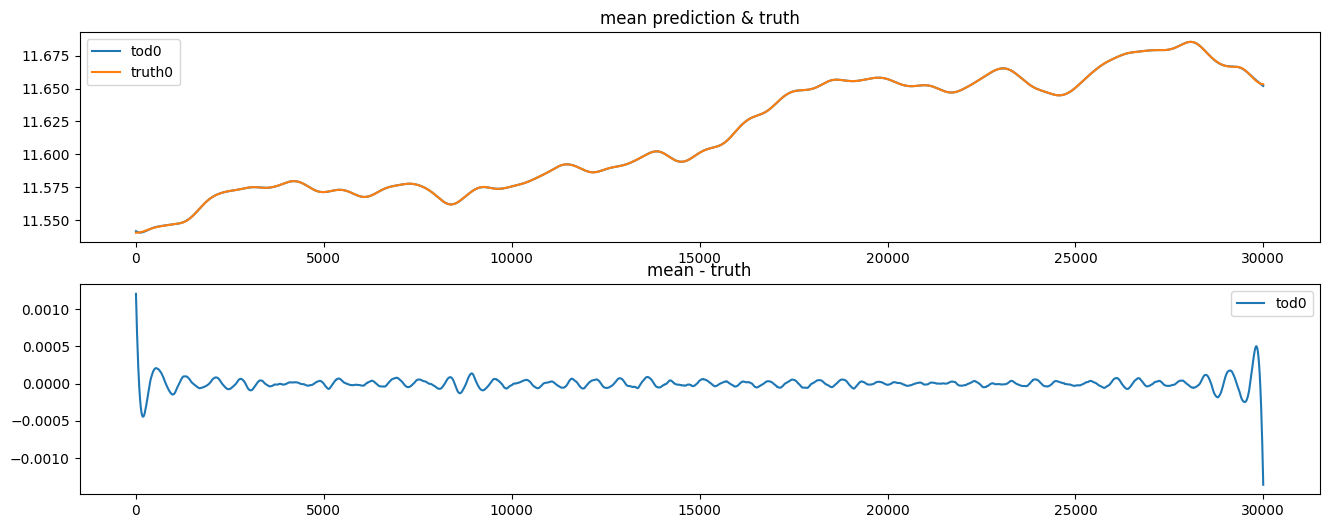

OPTIMIZE_KL: Starting 0007
SL: Iteration 0 ⛰:+4.3357e+16 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+2.4484e+16 Δ⛰:1.8873e+16 ➽:3.2003e-08
SL: Iteration 2 ⛰:+1.2953e+16 Δ⛰:1.1531e+16 ➽:3.2003e-08
SL: Iteration 3 ⛰:+1.1992e+15 Δ⛰:1.1754e+16 ➽:3.2003e-08
SL: Iteration 4 ⛰:+6.4313e+14 Δ⛰:5.5605e+14 ➽:3.2003e-08
SL: Iteration 5 ⛰:+3.5549e+14 Δ⛰:2.8764e+14 ➽:3.2003e-08
SL: Iteration 6 ⛰:+2.1999e+14 Δ⛰:1.3550e+14 ➽:3.2003e-08
SL: Iteration 7 ⛰:+1.0688e+14 Δ⛰:1.1312e+14 ➽:3.2003e-08
SL: Iteration 8 ⛰:+9.1763e+13 Δ⛰:1.5114e+13 ➽:3.2003e-08
SL: Iteration 9 ⛰:+7.0885e+13 Δ⛰:2.0878e+13 ➽:3.2003e-08
SL: Iteration 10 ⛰:+3.9391e+13 Δ⛰:3.1493e+13 ➽:3.2003e-08
SL: Iteration 11 ⛰:+3.9284e+13 Δ⛰:1.0726e+11 ➽:3.2003e-08
SL: Iteration 12 ⛰:+2.9023e+13 Δ⛰:1.0261e+13 ➽:3.2003e-08
SL: Iteration 13 ⛰:+1.7480e+13 Δ⛰:1.1543e+13 ➽:3.2003e-08
SL: Iteration 14 ⛰:+1.7453e+13 Δ⛰:2.6231e+10 ➽:3.2003e-08
SL: Iteration 15 ⛰:+1.7444e+13 Δ⛰:9.3723e+09 ➽:3.2003e-08
SL: Iteration 16 ⛰:+1.3406e+13 Δ⛰:4.0381e+12 ➽:3.2003e-08
SL: 

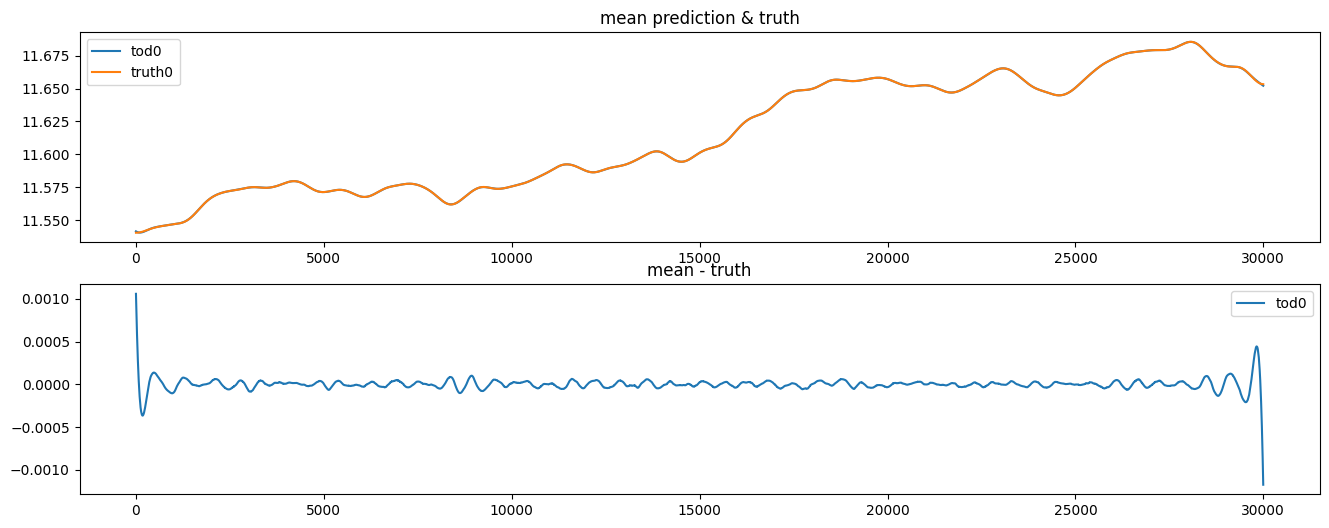

OPTIMIZE_KL: Starting 0008
SL: Iteration 0 ⛰:+4.1542e+16 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+1.0883e+16 Δ⛰:3.0660e+16 ➽:3.2003e-08
SL: Iteration 2 ⛰:+1.5085e+15 Δ⛰:9.3740e+15 ➽:3.2003e-08
SL: Iteration 3 ⛰:+1.1681e+15 Δ⛰:3.4045e+14 ➽:3.2003e-08
SL: Iteration 4 ⛰:+8.8411e+14 Δ⛰:2.8399e+14 ➽:3.2003e-08
SL: Iteration 5 ⛰:+2.5084e+14 Δ⛰:6.3327e+14 ➽:3.2003e-08
SL: Iteration 6 ⛰:+1.7438e+14 Δ⛰:7.6460e+13 ➽:3.2003e-08
SL: Iteration 7 ⛰:+5.2170e+13 Δ⛰:1.2221e+14 ➽:3.2003e-08
SL: Iteration 8 ⛰:+4.3228e+13 Δ⛰:8.9426e+12 ➽:3.2003e-08
SL: Iteration 9 ⛰:+4.2545e+13 Δ⛰:6.8277e+11 ➽:3.2003e-08
SL: Iteration 10 ⛰:+3.3755e+13 Δ⛰:8.7896e+12 ➽:3.2003e-08
SL: Iteration 11 ⛰:+3.3732e+13 Δ⛰:2.3702e+10 ➽:3.2003e-08
SL: Iteration 12 ⛰:+2.8608e+13 Δ⛰:5.1236e+12 ➽:3.2003e-08
SL: Iteration 13 ⛰:+2.4672e+13 Δ⛰:3.9358e+12 ➽:3.2003e-08
SL: Iteration 14 ⛰:+2.1387e+13 Δ⛰:3.2855e+12 ➽:3.2003e-08
SL: Iteration 15 ⛰:+2.0889e+13 Δ⛰:4.9742e+11 ➽:3.2003e-08
SL: Iteration 16 ⛰:+1.7281e+13 Δ⛰:3.6087e+12 ➽:3.2003e-08
SL: 

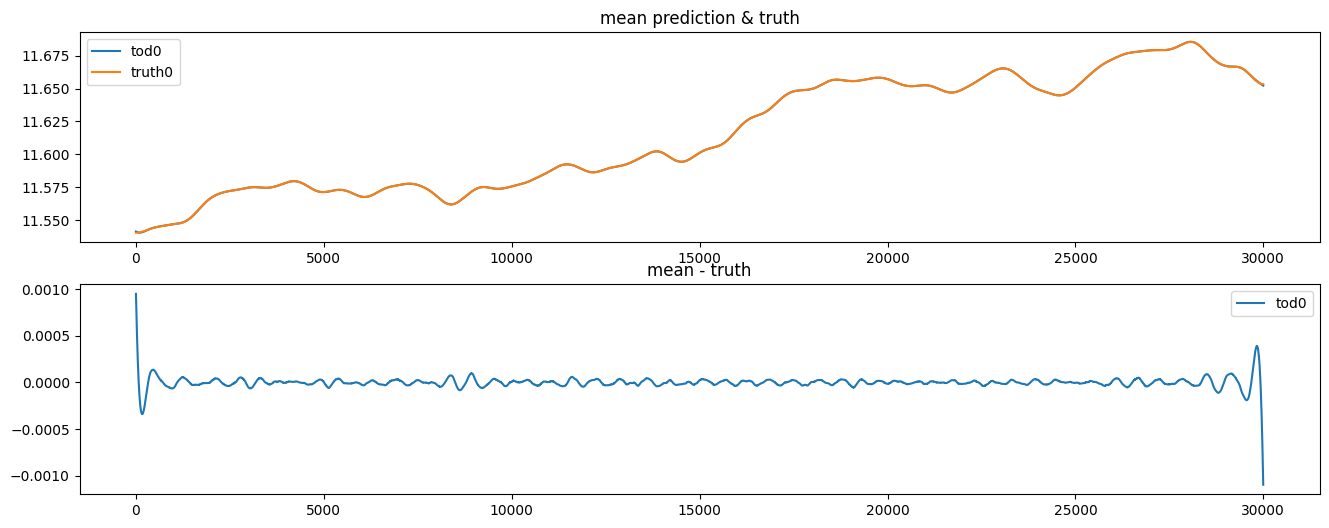

OPTIMIZE_KL: Starting 0009
SL: Iteration 0 ⛰:+3.0648e+17 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+7.6275e+16 Δ⛰:2.3021e+17 ➽:3.2003e-08
SL: Iteration 2 ⛰:+3.0049e+16 Δ⛰:4.6226e+16 ➽:3.2003e-08
SL: Iteration 3 ⛰:+1.3521e+16 Δ⛰:1.6528e+16 ➽:3.2003e-08
SL: Iteration 4 ⛰:+9.8469e+14 Δ⛰:1.2536e+16 ➽:3.2003e-08
SL: Iteration 5 ⛰:+2.8166e+14 Δ⛰:7.0303e+14 ➽:3.2003e-08
SL: Iteration 6 ⛰:+2.2250e+14 Δ⛰:5.9159e+13 ➽:3.2003e-08
SL: Iteration 7 ⛰:+1.1781e+14 Δ⛰:1.0469e+14 ➽:3.2003e-08
SL: Iteration 8 ⛰:+1.1778e+14 Δ⛰:3.1469e+10 ➽:3.2003e-08
SL: Iteration 9 ⛰:+8.2855e+13 Δ⛰:3.4927e+13 ➽:3.2003e-08
SL: Iteration 10 ⛰:+5.1467e+13 Δ⛰:3.1388e+13 ➽:3.2003e-08
SL: Iteration 11 ⛰:+4.6461e+13 Δ⛰:5.0058e+12 ➽:3.2003e-08
SL: Iteration 12 ⛰:+2.5579e+13 Δ⛰:2.0882e+13 ➽:3.2003e-08
SL: Iteration 13 ⛰:+2.0371e+13 Δ⛰:5.2082e+12 ➽:3.2003e-08
SL: Iteration 14 ⛰:+2.0303e+13 Δ⛰:6.7530e+10 ➽:3.2003e-08
SL: Iteration 15 ⛰:+2.0287e+13 Δ⛰:1.5891e+10 ➽:3.2003e-08
SL: Iteration 16 ⛰:+1.4473e+13 Δ⛰:5.8144e+12 ➽:3.2003e-08
SL: 

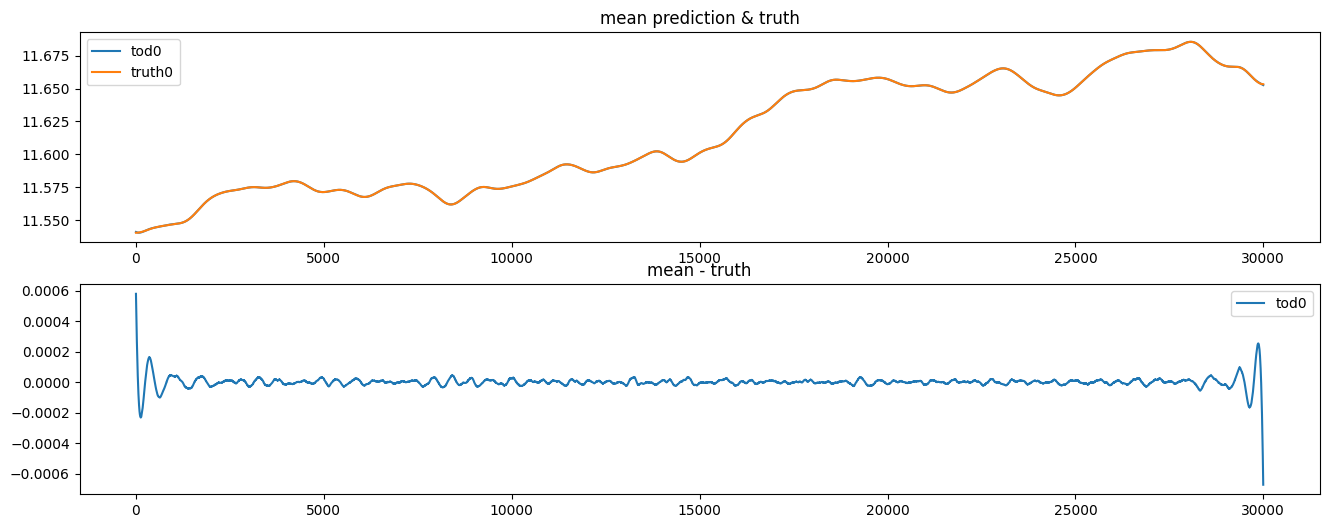

OPTIMIZE_KL: Starting 0010
SL: Iteration 0 ⛰:+1.5459e+16 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+1.4830e+16 Δ⛰:6.2915e+14 ➽:3.2003e-08
SL: Iteration 2 ⛰:+4.3437e+15 Δ⛰:1.0486e+16 ➽:3.2003e-08
SL: Iteration 3 ⛰:+2.3345e+15 Δ⛰:2.0091e+15 ➽:3.2003e-08
SL: Iteration 4 ⛰:+2.2154e+15 Δ⛰:1.1914e+14 ➽:3.2003e-08
SL: Iteration 5 ⛰:+7.4574e+14 Δ⛰:1.4697e+15 ➽:3.2003e-08
SL: Iteration 6 ⛰:+4.2222e+14 Δ⛰:3.2352e+14 ➽:3.2003e-08
SL: Iteration 7 ⛰:+1.1568e+14 Δ⛰:3.0655e+14 ➽:3.2003e-08
SL: Iteration 8 ⛰:+8.6141e+13 Δ⛰:2.9536e+13 ➽:3.2003e-08
SL: Iteration 9 ⛰:+8.5898e+13 Δ⛰:2.4286e+11 ➽:3.2003e-08
SL: Iteration 10 ⛰:+4.8204e+13 Δ⛰:3.7694e+13 ➽:3.2003e-08
SL: Iteration 11 ⛰:+3.2252e+13 Δ⛰:1.5952e+13 ➽:3.2003e-08
SL: Iteration 12 ⛰:+2.8043e+13 Δ⛰:4.2089e+12 ➽:3.2003e-08
SL: Iteration 13 ⛰:+1.8570e+13 Δ⛰:9.4733e+12 ➽:3.2003e-08
SL: Iteration 14 ⛰:+1.2809e+13 Δ⛰:5.7615e+12 ➽:3.2003e-08
SL: Iteration 15 ⛰:+1.2731e+13 Δ⛰:7.7994e+10 ➽:3.2003e-08
SL: Iteration 16 ⛰:+1.2419e+13 Δ⛰:3.1139e+11 ➽:3.2003e-08
SL: 

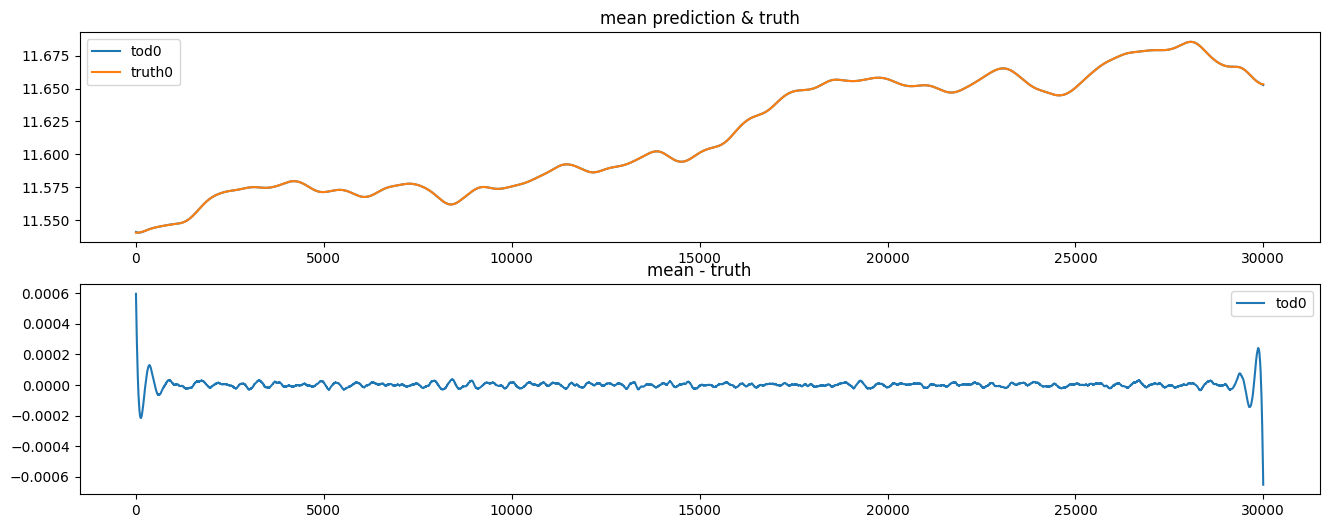

OPTIMIZE_KL: Starting 0011
SL: Iteration 0 ⛰:+1.2835e+17 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+1.1963e+16 Δ⛰:1.1638e+17 ➽:3.2003e-08
SL: Iteration 2 ⛰:+4.9636e+15 Δ⛰:6.9991e+15 ➽:3.2003e-08
SL: Iteration 3 ⛰:+1.3226e+15 Δ⛰:3.6410e+15 ➽:3.2003e-08
SL: Iteration 4 ⛰:+6.4427e+14 Δ⛰:6.7833e+14 ➽:3.2003e-08
SL: Iteration 5 ⛰:+3.3012e+14 Δ⛰:3.1416e+14 ➽:3.2003e-08
SL: Iteration 6 ⛰:+3.0627e+14 Δ⛰:2.3843e+13 ➽:3.2003e-08
SL: Iteration 7 ⛰:+1.4870e+14 Δ⛰:1.5758e+14 ➽:3.2003e-08
SL: Iteration 8 ⛰:+1.4828e+14 Δ⛰:4.1310e+11 ➽:3.2003e-08
SL: Iteration 9 ⛰:+9.8532e+13 Δ⛰:4.9752e+13 ➽:3.2003e-08
SL: Iteration 10 ⛰:+5.3442e+13 Δ⛰:4.5090e+13 ➽:3.2003e-08
SL: Iteration 11 ⛰:+5.3405e+13 Δ⛰:3.6611e+10 ➽:3.2003e-08
SL: Iteration 12 ⛰:+4.0483e+13 Δ⛰:1.2922e+13 ➽:3.2003e-08
SL: Iteration 13 ⛰:+2.0568e+13 Δ⛰:1.9916e+13 ➽:3.2003e-08
SL: Iteration 14 ⛰:+1.8375e+13 Δ⛰:2.1927e+12 ➽:3.2003e-08
SL: Iteration 15 ⛰:+1.8364e+13 Δ⛰:1.1014e+10 ➽:3.2003e-08
SL: Iteration 16 ⛰:+1.0384e+13 Δ⛰:7.9806e+12 ➽:3.2003e-08
SL: 

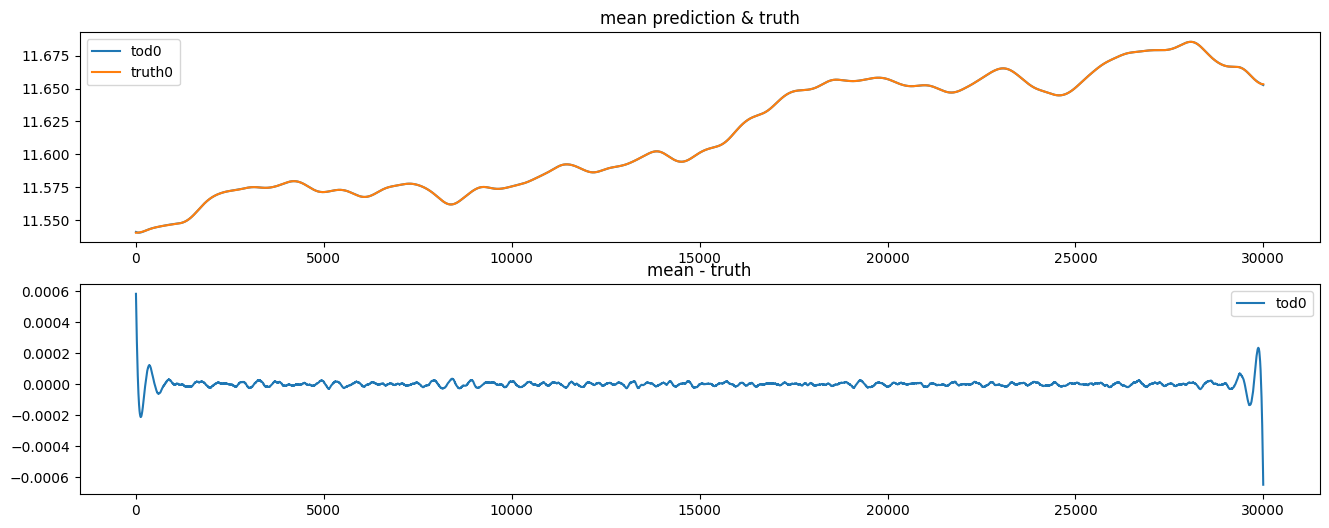

OPTIMIZE_KL: Starting 0012
SL: Iteration 0 ⛰:+1.7902e+17 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+5.5387e+16 Δ⛰:1.2363e+17 ➽:3.2003e-08
SL: Iteration 2 ⛰:+7.1477e+15 Δ⛰:4.8240e+16 ➽:3.2003e-08
SL: Iteration 3 ⛰:+3.1269e+15 Δ⛰:4.0208e+15 ➽:3.2003e-08
SL: Iteration 4 ⛰:+1.3898e+15 Δ⛰:1.7370e+15 ➽:3.2003e-08
SL: Iteration 5 ⛰:+4.0530e+14 Δ⛰:9.8453e+14 ➽:3.2003e-08
SL: Iteration 6 ⛰:+3.5624e+14 Δ⛰:4.9055e+13 ➽:3.2003e-08
SL: Iteration 7 ⛰:+1.4130e+14 Δ⛰:2.1494e+14 ➽:3.2003e-08
SL: Iteration 8 ⛰:+1.3897e+14 Δ⛰:2.3251e+12 ➽:3.2003e-08
SL: Iteration 9 ⛰:+7.5292e+13 Δ⛰:6.3678e+13 ➽:3.2003e-08
SL: Iteration 10 ⛰:+3.3345e+13 Δ⛰:4.1947e+13 ➽:3.2003e-08
SL: Iteration 11 ⛰:+3.3109e+13 Δ⛰:2.3597e+11 ➽:3.2003e-08
SL: Iteration 12 ⛰:+2.5962e+13 Δ⛰:7.1474e+12 ➽:3.2003e-08
SL: Iteration 13 ⛰:+1.4944e+13 Δ⛰:1.1018e+13 ➽:3.2003e-08
SL: Iteration 14 ⛰:+1.4057e+13 Δ⛰:8.8685e+11 ➽:3.2003e-08
SL: Iteration 15 ⛰:+1.4052e+13 Δ⛰:4.4230e+09 ➽:3.2003e-08
SL: Iteration 16 ⛰:+9.7907e+12 Δ⛰:4.2616e+12 ➽:3.2003e-08
SL: 

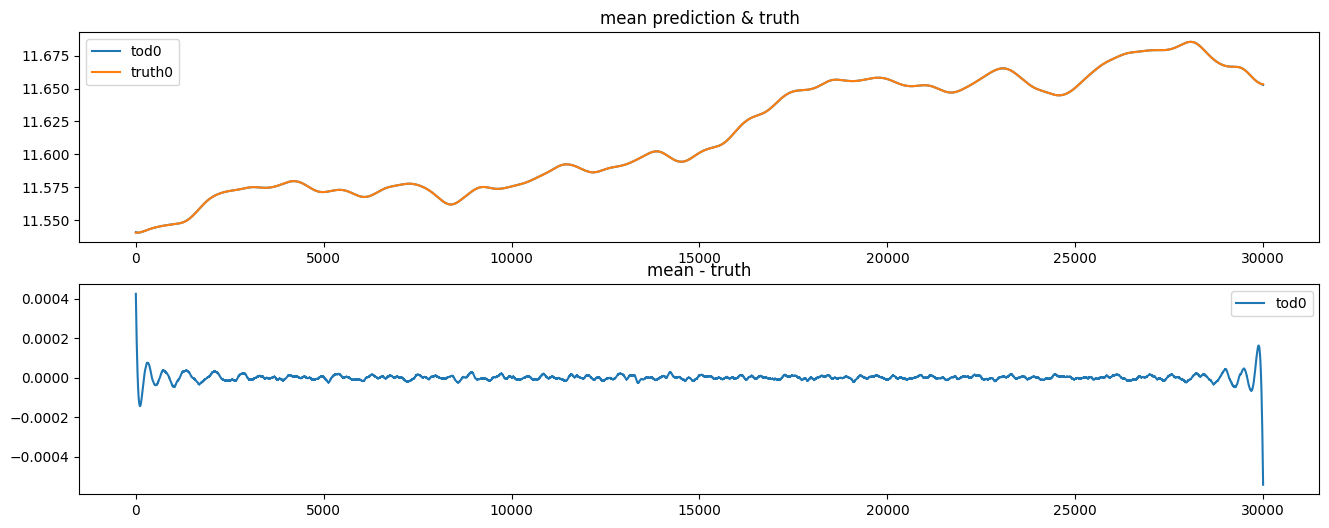

OPTIMIZE_KL: Starting 0013
SL: Iteration 0 ⛰:+1.5305e+17 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+3.4361e+16 Δ⛰:1.1869e+17 ➽:3.2003e-08
SL: Iteration 2 ⛰:+1.0995e+16 Δ⛰:2.3367e+16 ➽:3.2003e-08
SL: Iteration 3 ⛰:+4.8769e+15 Δ⛰:6.1179e+15 ➽:3.2003e-08
SL: Iteration 4 ⛰:+1.9270e+15 Δ⛰:2.9498e+15 ➽:3.2003e-08
SL: Iteration 5 ⛰:+5.9078e+14 Δ⛰:1.3362e+15 ➽:3.2003e-08
SL: Iteration 6 ⛰:+4.1381e+14 Δ⛰:1.7697e+14 ➽:3.2003e-08
SL: Iteration 7 ⛰:+7.1076e+13 Δ⛰:3.4274e+14 ➽:3.2003e-08
SL: Iteration 8 ⛰:+5.3169e+13 Δ⛰:1.7907e+13 ➽:3.2003e-08
SL: Iteration 9 ⛰:+4.6017e+13 Δ⛰:7.1523e+12 ➽:3.2003e-08
SL: Iteration 10 ⛰:+3.4235e+13 Δ⛰:1.1782e+13 ➽:3.2003e-08
SL: Iteration 11 ⛰:+3.2974e+13 Δ⛰:1.2605e+12 ➽:3.2003e-08
SL: Iteration 12 ⛰:+2.5962e+13 Δ⛰:7.0124e+12 ➽:3.2003e-08
SL: Iteration 13 ⛰:+2.2159e+13 Δ⛰:3.8028e+12 ➽:3.2003e-08
SL: Iteration 14 ⛰:+2.2031e+13 Δ⛰:1.2778e+11 ➽:3.2003e-08
SL: Iteration 15 ⛰:+2.2026e+13 Δ⛰:4.9145e+09 ➽:3.2003e-08
SL: Iteration 16 ⛰:+1.5458e+13 Δ⛰:6.5678e+12 ➽:3.2003e-08
SL: 

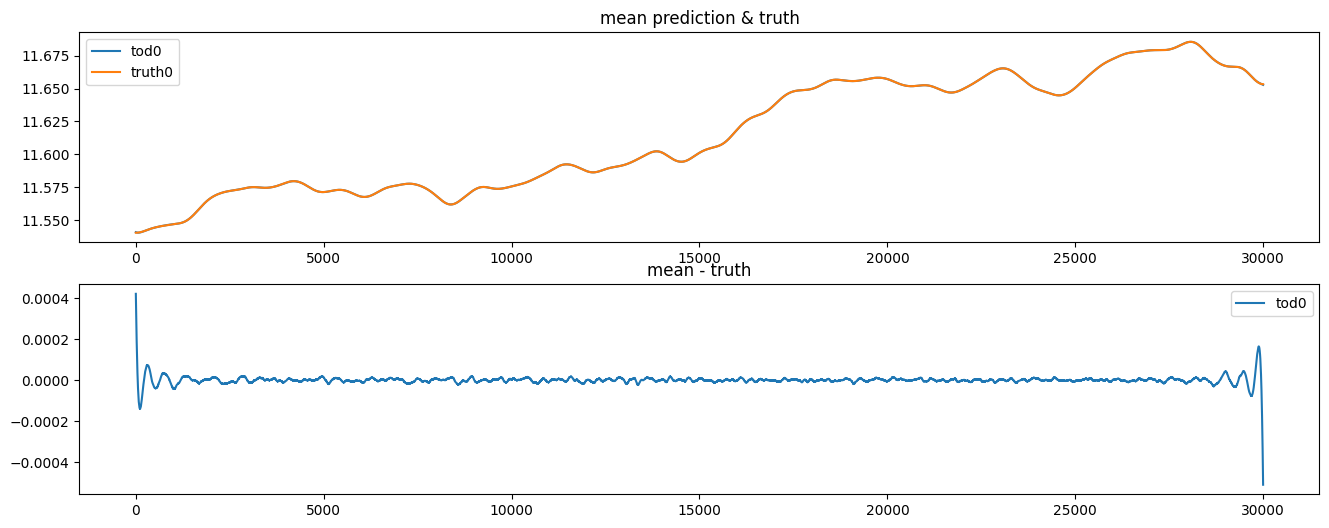

OPTIMIZE_KL: Starting 0014
SL: Iteration 0 ⛰:+2.5867e+17 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+3.3770e+16 Δ⛰:2.2490e+17 ➽:3.2003e-08
SL: Iteration 2 ⛰:+1.3240e+16 Δ⛰:2.0530e+16 ➽:3.2003e-08
SL: Iteration 3 ⛰:+4.1957e+15 Δ⛰:9.0444e+15 ➽:3.2003e-08
SL: Iteration 4 ⛰:+1.2192e+15 Δ⛰:2.9765e+15 ➽:3.2003e-08
SL: Iteration 5 ⛰:+3.1604e+14 Δ⛰:9.0317e+14 ➽:3.2003e-08
SL: Iteration 6 ⛰:+2.1977e+14 Δ⛰:9.6267e+13 ➽:3.2003e-08
SL: Iteration 7 ⛰:+9.7778e+13 Δ⛰:1.2200e+14 ➽:3.2003e-08
SL: Iteration 8 ⛰:+8.6991e+13 Δ⛰:1.0787e+13 ➽:3.2003e-08
SL: Iteration 9 ⛰:+8.3541e+13 Δ⛰:3.4498e+12 ➽:3.2003e-08
SL: Iteration 10 ⛰:+4.8342e+13 Δ⛰:3.5199e+13 ➽:3.2003e-08
SL: Iteration 11 ⛰:+4.8215e+13 Δ⛰:1.2736e+11 ➽:3.2003e-08
SL: Iteration 12 ⛰:+3.3750e+13 Δ⛰:1.4464e+13 ➽:3.2003e-08
SL: Iteration 13 ⛰:+1.9019e+13 Δ⛰:1.4731e+13 ➽:3.2003e-08
SL: Iteration 14 ⛰:+1.5304e+13 Δ⛰:3.7152e+12 ➽:3.2003e-08
SL: Iteration 15 ⛰:+1.5300e+13 Δ⛰:4.3050e+09 ➽:3.2003e-08
SL: Iteration 16 ⛰:+1.1890e+13 Δ⛰:3.4095e+12 ➽:3.2003e-08
SL: 

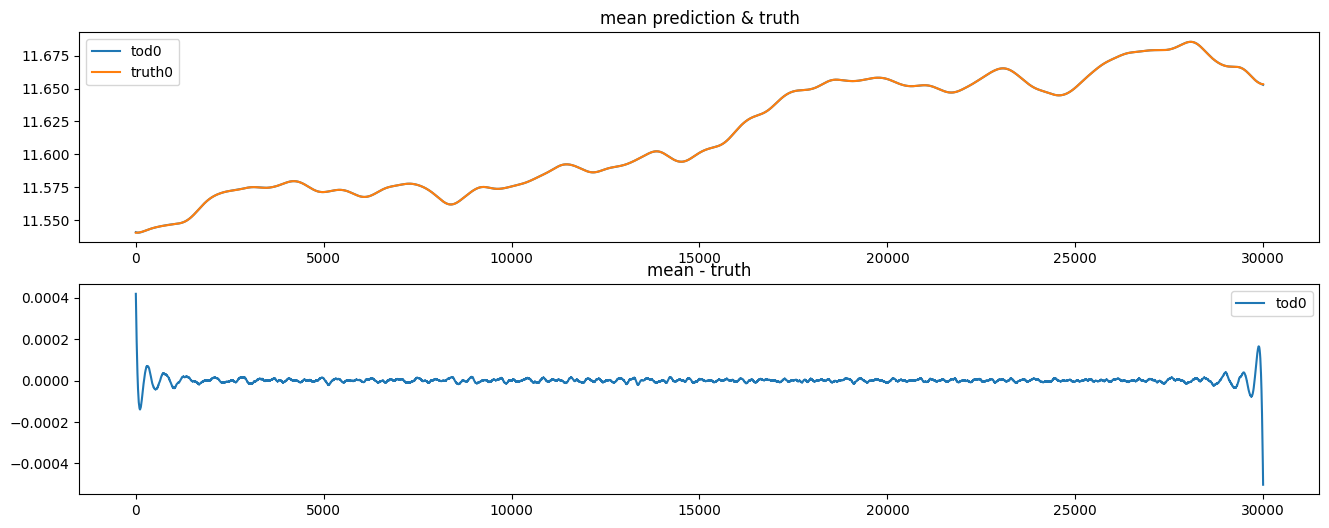

OPTIMIZE_KL: Starting 0015
SL: Iteration 0 ⛰:+1.0483e+17 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+3.0112e+16 Δ⛰:7.4717e+16 ➽:3.2003e-08
SL: Iteration 2 ⛰:+3.0339e+15 Δ⛰:2.7078e+16 ➽:3.2003e-08
SL: Iteration 3 ⛰:+2.0077e+15 Δ⛰:1.0262e+15 ➽:3.2003e-08
SL: Iteration 4 ⛰:+1.0612e+15 Δ⛰:9.4648e+14 ➽:3.2003e-08
SL: Iteration 5 ⛰:+4.5976e+14 Δ⛰:6.0146e+14 ➽:3.2003e-08
SL: Iteration 6 ⛰:+3.2389e+14 Δ⛰:1.3587e+14 ➽:3.2003e-08
SL: Iteration 7 ⛰:+1.0644e+14 Δ⛰:2.1746e+14 ➽:3.2003e-08
SL: Iteration 8 ⛰:+9.8493e+13 Δ⛰:7.9446e+12 ➽:3.2003e-08
SL: Iteration 9 ⛰:+4.9782e+13 Δ⛰:4.8711e+13 ➽:3.2003e-08
SL: Iteration 10 ⛰:+2.9427e+13 Δ⛰:2.0356e+13 ➽:3.2003e-08
SL: Iteration 11 ⛰:+2.9371e+13 Δ⛰:5.5599e+10 ➽:3.2003e-08
SL: Iteration 12 ⛰:+1.9454e+13 Δ⛰:9.9169e+12 ➽:3.2003e-08
SL: Iteration 13 ⛰:+1.4212e+13 Δ⛰:5.2424e+12 ➽:3.2003e-08
SL: Iteration 14 ⛰:+1.3999e+13 Δ⛰:2.1298e+11 ➽:3.2003e-08
SL: Iteration 15 ⛰:+1.3883e+13 Δ⛰:1.1558e+11 ➽:3.2003e-08
SL: Iteration 16 ⛰:+9.9946e+12 Δ⛰:3.8886e+12 ➽:3.2003e-08
SL: 

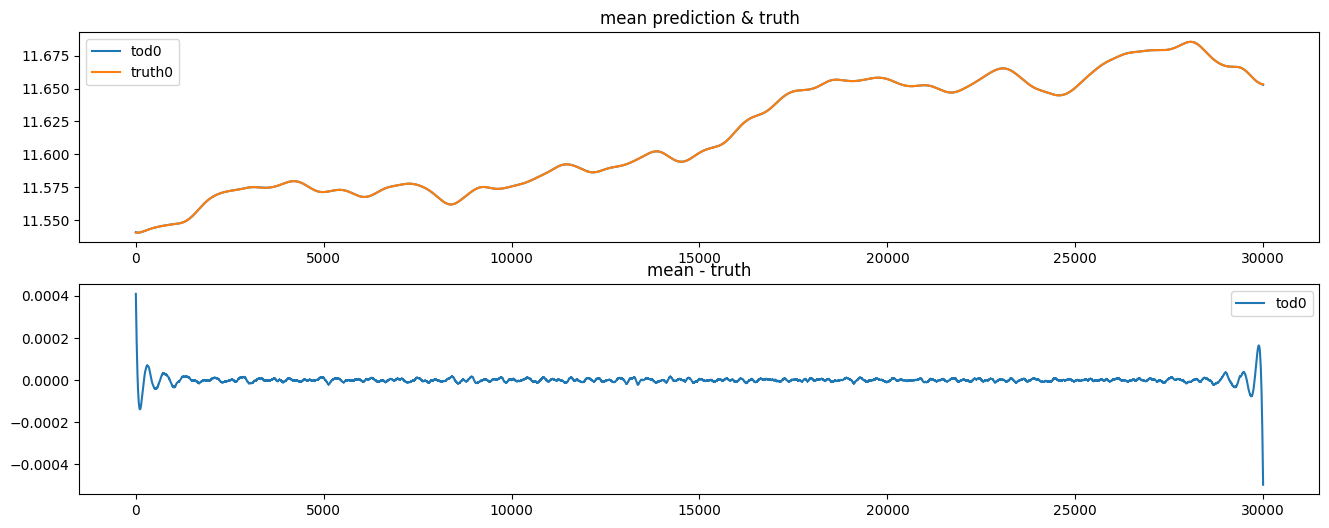

OPTIMIZE_KL: Starting 0016
SL: Iteration 0 ⛰:+7.2730e+16 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+2.0500e+16 Δ⛰:5.2230e+16 ➽:3.2003e-08
SL: Iteration 2 ⛰:+8.1128e+15 Δ⛰:1.2387e+16 ➽:3.2003e-08
SL: Iteration 3 ⛰:+5.0259e+15 Δ⛰:3.0869e+15 ➽:3.2003e-08
SL: Iteration 4 ⛰:+1.5804e+15 Δ⛰:3.4455e+15 ➽:3.2003e-08
SL: Iteration 5 ⛰:+5.0997e+14 Δ⛰:1.0704e+15 ➽:3.2003e-08
SL: Iteration 6 ⛰:+3.2447e+14 Δ⛰:1.8550e+14 ➽:3.2003e-08
SL: Iteration 7 ⛰:+5.2016e+13 Δ⛰:2.7245e+14 ➽:3.2003e-08
SL: Iteration 8 ⛰:+3.5643e+13 Δ⛰:1.6374e+13 ➽:3.2003e-08
SL: Iteration 9 ⛰:+3.3929e+13 Δ⛰:1.7134e+12 ➽:3.2003e-08
SL: Iteration 10 ⛰:+2.0582e+13 Δ⛰:1.3347e+13 ➽:3.2003e-08
SL: Iteration 11 ⛰:+2.0551e+13 Δ⛰:3.1597e+10 ➽:3.2003e-08
SL: Iteration 12 ⛰:+1.7599e+13 Δ⛰:2.9514e+12 ➽:3.2003e-08
SL: Iteration 13 ⛰:+1.1849e+13 Δ⛰:5.7506e+12 ➽:3.2003e-08
SL: Iteration 14 ⛰:+1.1709e+13 Δ⛰:1.3967e+11 ➽:3.2003e-08
SL: Iteration 15 ⛰:+1.1683e+13 Δ⛰:2.5932e+10 ➽:3.2003e-08
SL: Iteration 16 ⛰:+9.7303e+12 Δ⛰:1.9527e+12 ➽:3.2003e-08
SL: 

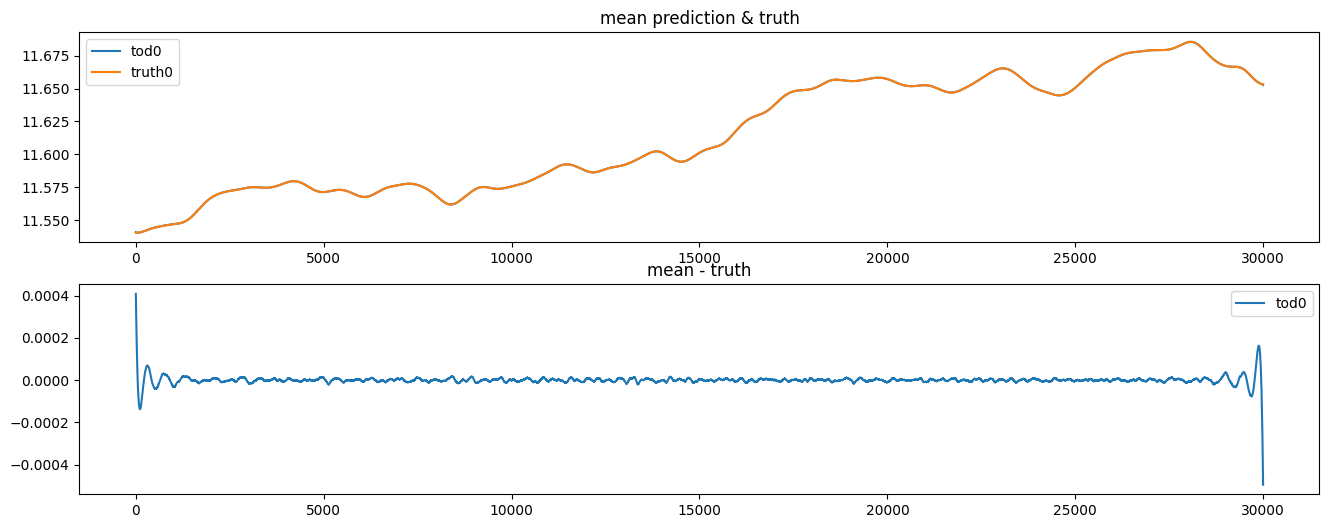

OPTIMIZE_KL: Starting 0017
SL: Iteration 0 ⛰:+2.5180e+17 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+1.0262e+17 Δ⛰:1.4918e+17 ➽:3.2003e-08
SL: Iteration 2 ⛰:+1.5050e+16 Δ⛰:8.7568e+16 ➽:3.2003e-08
SL: Iteration 3 ⛰:+4.1517e+15 Δ⛰:1.0898e+16 ➽:3.2003e-08
SL: Iteration 4 ⛰:+1.2051e+15 Δ⛰:2.9466e+15 ➽:3.2003e-08
SL: Iteration 5 ⛰:+3.7719e+14 Δ⛰:8.2796e+14 ➽:3.2003e-08
SL: Iteration 6 ⛰:+2.8604e+14 Δ⛰:9.1157e+13 ➽:3.2003e-08
SL: Iteration 7 ⛰:+7.9981e+13 Δ⛰:2.0605e+14 ➽:3.2003e-08
SL: Iteration 8 ⛰:+7.9922e+13 Δ⛰:5.9153e+10 ➽:3.2003e-08
SL: Iteration 9 ⛰:+6.2222e+13 Δ⛰:1.7699e+13 ➽:3.2003e-08
SL: Iteration 10 ⛰:+3.2872e+13 Δ⛰:2.9350e+13 ➽:3.2003e-08
SL: Iteration 11 ⛰:+2.9720e+13 Δ⛰:3.1516e+12 ➽:3.2003e-08
SL: Iteration 12 ⛰:+2.3114e+13 Δ⛰:6.6067e+12 ➽:3.2003e-08
SL: Iteration 13 ⛰:+1.3799e+13 Δ⛰:9.3144e+12 ➽:3.2003e-08
SL: Iteration 14 ⛰:+1.3736e+13 Δ⛰:6.3589e+10 ➽:3.2003e-08
SL: Iteration 15 ⛰:+1.3724e+13 Δ⛰:1.1342e+10 ➽:3.2003e-08
SL: Iteration 16 ⛰:+1.1786e+13 Δ⛰:1.9383e+12 ➽:3.2003e-08
SL: 

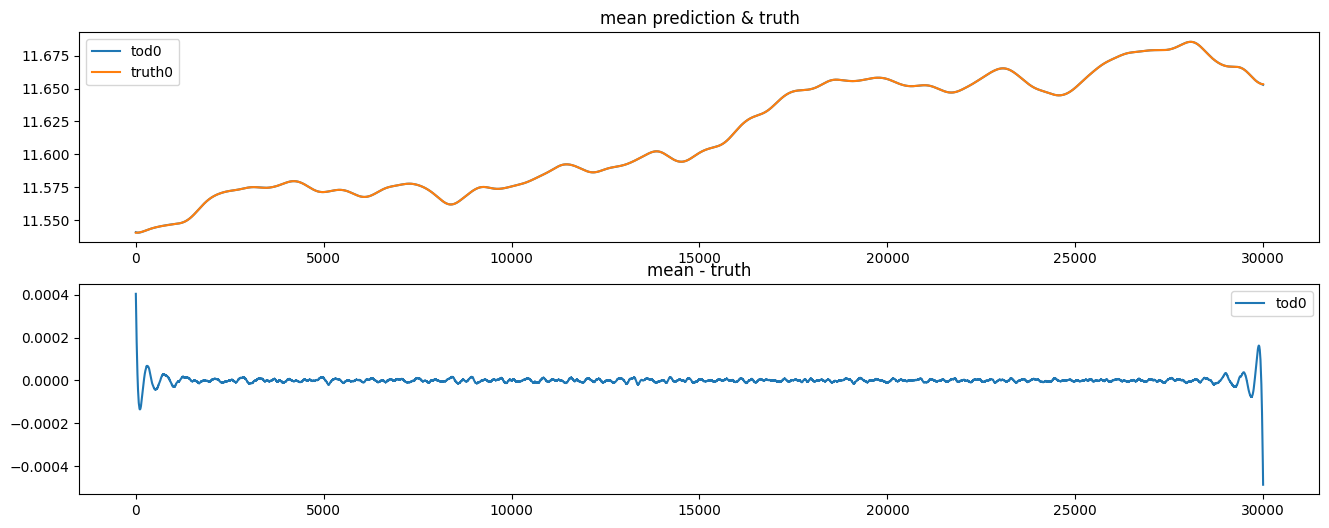

OPTIMIZE_KL: Starting 0018
SL: Iteration 0 ⛰:+9.4758e+16 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+4.8463e+16 Δ⛰:4.6295e+16 ➽:3.2003e-08
SL: Iteration 2 ⛰:+9.7503e+15 Δ⛰:3.8713e+16 ➽:3.2003e-08
SL: Iteration 3 ⛰:+6.7932e+15 Δ⛰:2.9571e+15 ➽:3.2003e-08
SL: Iteration 4 ⛰:+4.4202e+14 Δ⛰:6.3512e+15 ➽:3.2003e-08
SL: Iteration 5 ⛰:+1.5753e+14 Δ⛰:2.8449e+14 ➽:3.2003e-08
SL: Iteration 6 ⛰:+9.6464e+13 Δ⛰:6.1070e+13 ➽:3.2003e-08
SL: Iteration 7 ⛰:+5.9435e+13 Δ⛰:3.7029e+13 ➽:3.2003e-08
SL: Iteration 8 ⛰:+5.9371e+13 Δ⛰:6.3557e+10 ➽:3.2003e-08
SL: Iteration 9 ⛰:+4.7641e+13 Δ⛰:1.1730e+13 ➽:3.2003e-08
SL: Iteration 10 ⛰:+3.0017e+13 Δ⛰:1.7625e+13 ➽:3.2003e-08
SL: Iteration 11 ⛰:+2.5765e+13 Δ⛰:4.2518e+12 ➽:3.2003e-08
SL: Iteration 12 ⛰:+1.9273e+13 Δ⛰:6.4921e+12 ➽:3.2003e-08
SL: Iteration 13 ⛰:+1.2839e+13 Δ⛰:6.4336e+12 ➽:3.2003e-08
SL: Iteration 14 ⛰:+1.2832e+13 Δ⛰:6.6635e+09 ➽:3.2003e-08
SL: Iteration 15 ⛰:+1.0934e+13 Δ⛰:1.8983e+12 ➽:3.2003e-08
SL: Iteration 16 ⛰:+1.0520e+13 Δ⛰:4.1441e+11 ➽:3.2003e-08
SL: 

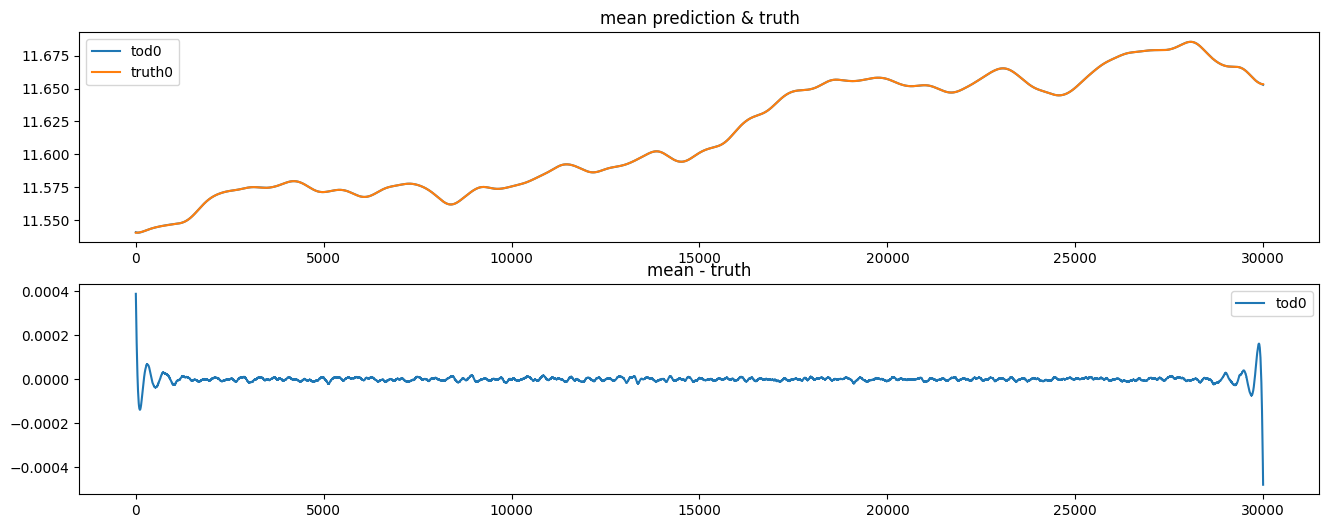

OPTIMIZE_KL: Starting 0019
SL: Iteration 0 ⛰:+6.9721e+16 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+4.8878e+16 Δ⛰:2.0843e+16 ➽:3.2003e-08
SL: Iteration 2 ⛰:+2.0354e+16 Δ⛰:2.8524e+16 ➽:3.2003e-08
SL: Iteration 3 ⛰:+3.2686e+15 Δ⛰:1.7085e+16 ➽:3.2003e-08
SL: Iteration 4 ⛰:+1.5747e+15 Δ⛰:1.6940e+15 ➽:3.2003e-08
SL: Iteration 5 ⛰:+2.6425e+14 Δ⛰:1.3104e+15 ➽:3.2003e-08
SL: Iteration 6 ⛰:+2.2166e+14 Δ⛰:4.2595e+13 ➽:3.2003e-08
SL: Iteration 7 ⛰:+9.2648e+13 Δ⛰:1.2901e+14 ➽:3.2003e-08
SL: Iteration 8 ⛰:+6.4016e+13 Δ⛰:2.8632e+13 ➽:3.2003e-08
SL: Iteration 9 ⛰:+6.3852e+13 Δ⛰:1.6370e+11 ➽:3.2003e-08
SL: Iteration 10 ⛰:+2.5952e+13 Δ⛰:3.7901e+13 ➽:3.2003e-08
SL: Iteration 11 ⛰:+2.5828e+13 Δ⛰:1.2384e+11 ➽:3.2003e-08
SL: Iteration 12 ⛰:+2.0050e+13 Δ⛰:5.7776e+12 ➽:3.2003e-08
SL: Iteration 13 ⛰:+1.9463e+13 Δ⛰:5.8705e+11 ➽:3.2003e-08
SL: Iteration 14 ⛰:+1.3193e+13 Δ⛰:6.2706e+12 ➽:3.2003e-08
SL: Iteration 15 ⛰:+1.2968e+13 Δ⛰:2.2486e+11 ➽:3.2003e-08
SL: Iteration 16 ⛰:+8.0737e+12 Δ⛰:4.8941e+12 ➽:3.2003e-08
SL: 

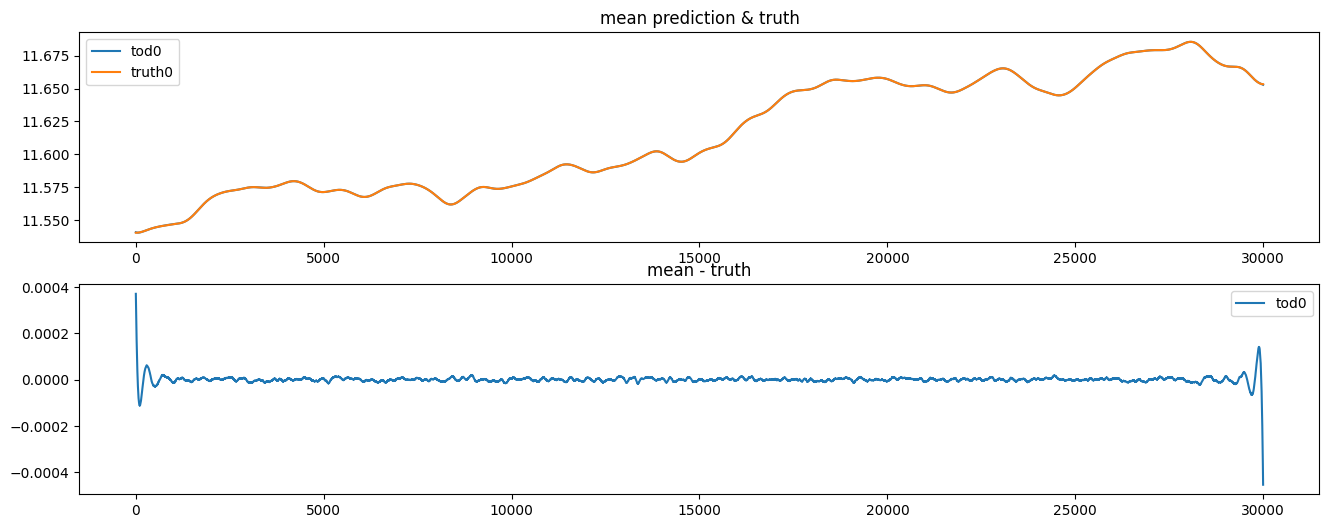

OPTIMIZE_KL: Starting 0020
SL: Iteration 0 ⛰:+7.2322e+17 Δ⛰:inf ➽:3.2003e-08
SL: Iteration 1 ⛰:+9.4528e+16 Δ⛰:6.2869e+17 ➽:3.2003e-08
SL: Iteration 2 ⛰:+6.1078e+14 Δ⛰:9.3918e+16 ➽:3.2003e-08
SL: Iteration 3 ⛰:+3.2268e+14 Δ⛰:2.8810e+14 ➽:3.2003e-08
SL: Iteration 4 ⛰:+1.8854e+14 Δ⛰:1.3414e+14 ➽:3.2003e-08
SL: Iteration 5 ⛰:+8.9787e+13 Δ⛰:9.8756e+13 ➽:3.2003e-08
SL: Iteration 6 ⛰:+7.1170e+13 Δ⛰:1.8617e+13 ➽:3.2003e-08
SL: Iteration 7 ⛰:+4.9959e+13 Δ⛰:2.1211e+13 ➽:3.2003e-08
SL: Iteration 8 ⛰:+4.9932e+13 Δ⛰:2.7254e+10 ➽:3.2003e-08
SL: Iteration 9 ⛰:+3.9709e+13 Δ⛰:1.0223e+13 ➽:3.2003e-08
SL: Iteration 10 ⛰:+2.5811e+13 Δ⛰:1.3898e+13 ➽:3.2003e-08
SL: Iteration 11 ⛰:+2.5657e+13 Δ⛰:1.5365e+11 ➽:3.2003e-08
SL: Iteration 12 ⛰:+1.7194e+13 Δ⛰:8.4636e+12 ➽:3.2003e-08
SL: Iteration 13 ⛰:+9.1476e+12 Δ⛰:8.0462e+12 ➽:3.2003e-08
SL: Iteration 14 ⛰:+9.1260e+12 Δ⛰:2.1620e+10 ➽:3.2003e-08
SL: Iteration 15 ⛰:+9.1064e+12 Δ⛰:1.9525e+10 ➽:3.2003e-08
SL: Iteration 16 ⛰:+7.9244e+12 Δ⛰:1.1820e+12 ➽:3.2003e-08
SL: 

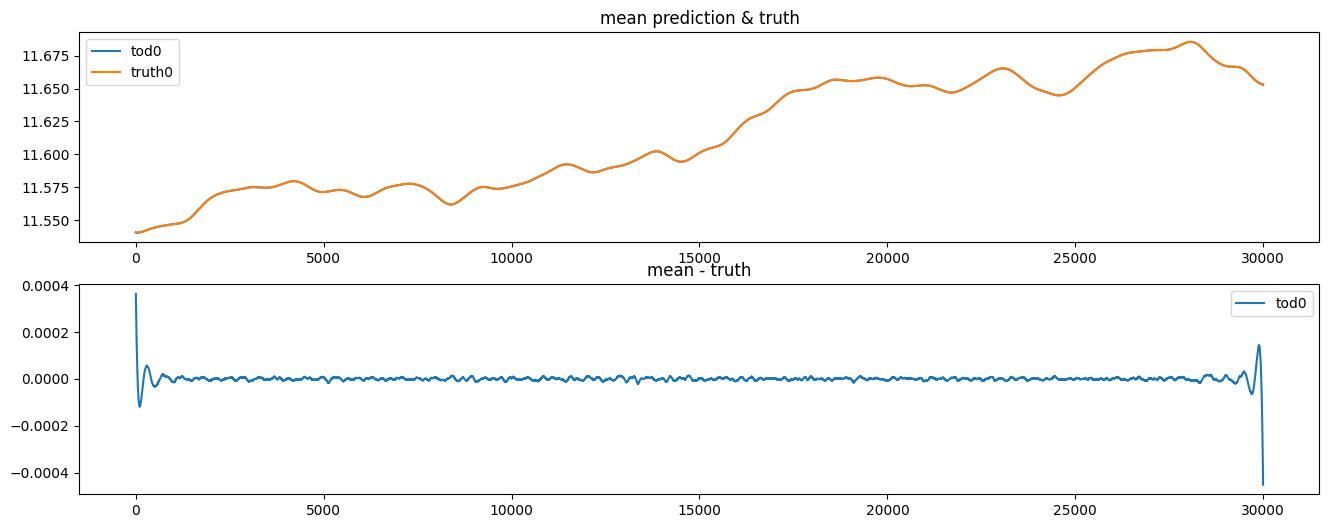

In [24]:
# n_it = 5
n_it = 20
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
# if noiselevel == 0.0: delta = 1e-6
if noiselevel == 0.0: delta = 1e-11
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

    fig_tods, axes_tods = plt.subplots(2, 1, figsize=(16, 6))

    # for i in range(0, mean.shape[0], mean.shape[0]//10):
    for i in range(n):
        axes_tods[0].plot(np.arange(0, mean.shape[1]), mean[i], label=f"tod{i}")
        axes_tods[0].plot(truth[i], label=f"truth{i}")
        axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - truth[i], label=f"tod{i}")

    axes_tods[0].title.set_text('mean prediction & truth')
    axes_tods[0].legend()
    axes_tods[1].title.set_text('mean - truth')
    axes_tods[1].legend()

    # fig_map, axes_map = plt.subplots(1, 3, figsize=(16, 8))

    # mean_map, _ = jft.mean_and_std(tuple(gp_map(s) for s in samples))

    # im0 = axes_map[0].imshow(mean_map)
    # axes_map[0].title.set_text('mean map pred.')
    # fig_map.colorbar(im0)

    # im1 = axes_map[1].imshow(mean_map - mapdata_truth[0])
    # axes_map[1].title.set_text('mean map - truth')
    # fig_map.colorbar(im1)

    # im2 = axes_map[2].imshow(mapdata_truth[0])
    # axes_map[2].title.set_text('truth')
    # fig_map.colorbar(im2)

    plt.show()
    

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=10),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=10
        )
    ),
    # sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    sample_mode = lambda x: "nonlinear_resample" if x >= 1 else "linear_resample",
    callback=callback,
)

In [25]:
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.027784039136610966, 0.005, 0.005
	loglogvarslope: -4.558172095757538, -3, 0.5
	zeromode std (LogNormal): 0.00013699356687579895, 0.0005, 0.001
	zeromode std (Normal): 0.00011379380575242322, 0.0005, 0.001


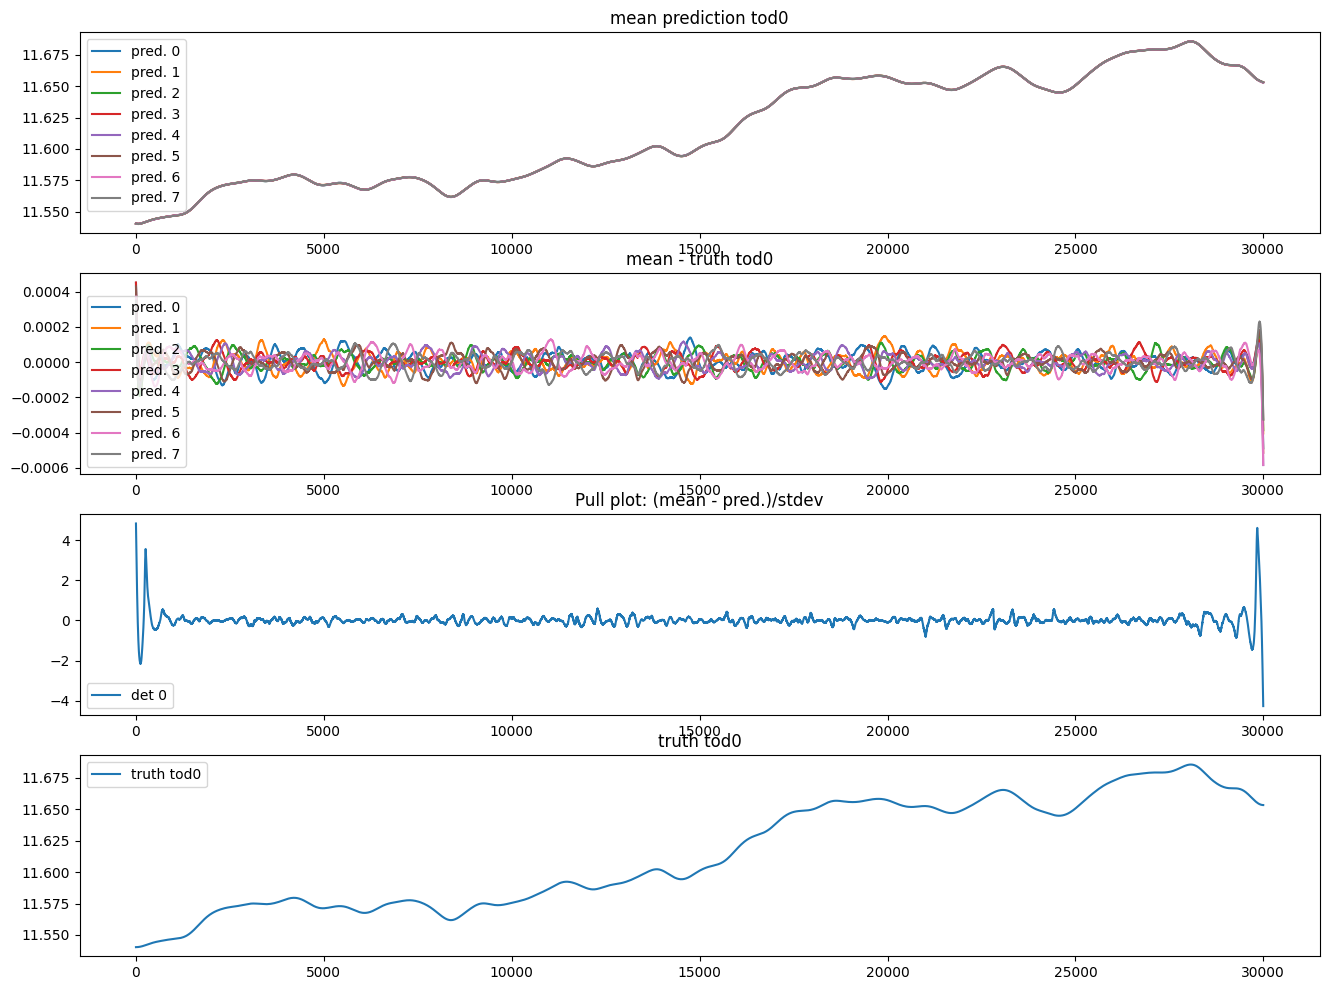

In [26]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 0
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - truth[i], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - truth[i])/std[i], label=f"det {i}")
im3 = axes[3].plot(truth[i], label=f"truth tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()